# Synthetic Data with strong interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
import numpy as np
from torch.distributions import MultivariateNormal
from ignite.utils import manual_seed

In [2]:
def jordan_se1(n_samples: int = 200, n_features: int = 2, rho: float = 0.0, noise_level: float = 0.1):
    features_indices = np.arange(1, n_features+1)
    col_indices, row_indices = np.meshgrid(features_indices, features_indices)
    power_matrix = np.abs(col_indices-row_indices)
    cov = torch.Tensor(rho**power_matrix)
    loc = torch.zeros(n_features)
    normal_dist = MultivariateNormal(loc, covariance_matrix=cov)
    X = normal_dist.sample((n_samples,))
    y_noise = X[:, 0] + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

In [3]:
def jordan_se2(n_samples: int = 300, n_features: int = 10, rho: float = 0.0, noise_level: float = 0.1):
    features_indices = np.arange(1, n_features+1)
    col_indices, row_indices = np.meshgrid(features_indices, features_indices)
    power_matrix = np.abs(col_indices-row_indices)
    cov = torch.Tensor(rho**power_matrix)
    loc = torch.zeros(n_features)
    normal_dist = MultivariateNormal(loc, covariance_matrix=cov)
    X = normal_dist.sample((n_samples,))
    y_noise = X[:, 0]**3 + X[:, 1]**3 + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

In [4]:
def jordan_se3(n_samples: int = 200, n_features: int = 10, noise_level: float = 0.1):
    X = torch.randn((n_samples, n_features))
    y_noise = X[:, 0] * X[:, 1] + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

### Visualizing

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

#### SE1

In [6]:
manual_seed(0)

In [7]:
X_se1, y_se1 = jordan_se1(rho=-0.5)

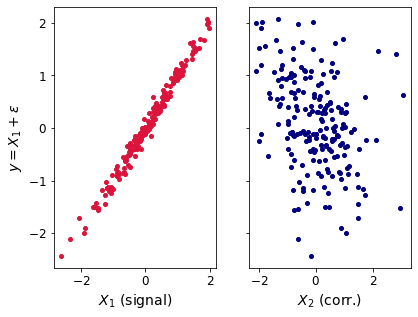

In [8]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_se1[:, 0], y_se1, 'o', markersize=4, color='crimson')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_se1[:, 1], y_se1, 'o', 
         markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
plt.show()

#### SE2

In [9]:
manual_seed(0)

In [10]:
X_se2, y_se2 = jordan_se2(rho=0.5)

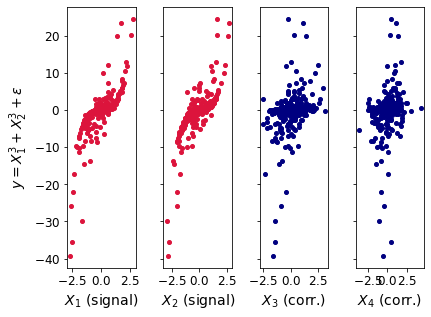

In [11]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se2[:, 0], y_se2, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_se2[:, 1], y_se2, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se2[:, i], y_se2, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

#### SE3

In [12]:
manual_seed(0)

In [13]:
X_se3, y_se3 = jordan_se3(noise_level=0.5)

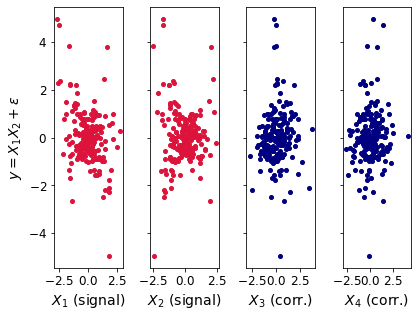

In [14]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se3[:, 0], y_se3, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_se3[:, 1], y_se3, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se3[:, i], y_se3, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Applying our method

In [15]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.pruners import MedianPruner
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Define custom loss function

In [16]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [17]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

### SE1

In [18]:
n_features = 2

In [19]:
train_size = 200
val_size = 100
test_size = 100

In [20]:
manual_seed(0)

In [21]:
X_se1, y_se1 = jordan_se1(n_samples=400, rho=0.5)

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se1, y_se1, train_size, val_size, test_size)

Generate datasets

In [23]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Prepare dataloaders

In [24]:
train_loader = DataLoader(train, batch_size=train_size)
val_loader = DataLoader(val, batch_size=val_size)
test_loader = DataLoader(test, batch_size=test_size)

Objective for optuna

In [25]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 50
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 100
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Optuna callback to save best model

In [26]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

Initalize optuna study

In [27]:
study = optuna.create_study(direction='minimize')

[I 2022-02-17 14:45:02,365] A new study created in memory with name: no-name-383cd839-59bc-4bc8-8865-fd903c47b197


Run study

In [28]:
n_epochs = 1050

In [29]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 100 Loss: 0.81015
Validation - Epoch: 100 Loss: 0.99626
Learning rate: 0.0015
Training - Epoch: 200 Loss: 0.79985
Validation - Epoch: 200 Loss: 0.98268
Learning rate: 0.0015
Training - Epoch: 300 Loss: 0.79079
Validation - Epoch: 300 Loss: 0.97150
Learning rate: 0.0015
Training - Epoch: 400 Loss: 0.77982
Validation - Epoch: 400 Loss: 0.95895
Learning rate: 0.0015
Training - Epoch: 500 Loss: 0.76538
Validation - Epoch: 500 Loss: 0.94316
Learning rate: 0.0015
Training - Epoch: 600 Loss: 0.75423
Validation - Epoch: 600 Loss: 0.93126
Learning rate: 0.0008
Training - Epoch: 700 Loss: 0.74387
Validation - Epoch: 700 Loss: 0.92037
Learning rate: 0.0008
Training - Epoch: 800 Loss: 0.73225
Validation - Epoch: 800 Loss: 0.90832
Learning rate: 0.0008
Training - Epoch: 900 Loss: 0.71936
Validation - Epoch: 900 Loss: 0.89514
Learning rate: 0.0008


[I 2022-02-17 14:45:07,348] Trial 0 finished with value: 0.8735263061523437 and parameters: {'learning_rate': 0.0015252312851222038, 'reg_param': 0.00021283002278667007}. Best is trial 0 with value: 0.8735263061523437.


Training - Epoch: 1000 Loss: 0.70525
Validation - Epoch: 1000 Loss: 0.88092
Learning rate: 0.0008
Training - Epoch: 100 Loss: 0.80637
Validation - Epoch: 100 Loss: 0.98737
Learning rate: 0.0020
Training - Epoch: 200 Loss: 0.80164
Validation - Epoch: 200 Loss: 0.98150
Learning rate: 0.0020
Training - Epoch: 300 Loss: 0.79367
Validation - Epoch: 300 Loss: 0.97203
Learning rate: 0.0020
Training - Epoch: 400 Loss: 0.77952
Validation - Epoch: 400 Loss: 0.95545
Learning rate: 0.0020
Training - Epoch: 500 Loss: 0.75508
Validation - Epoch: 500 Loss: 0.92710
Learning rate: 0.0020
Training - Epoch: 600 Loss: 0.73279
Validation - Epoch: 600 Loss: 0.90156
Learning rate: 0.0010
Training - Epoch: 700 Loss: 0.71022
Validation - Epoch: 700 Loss: 0.87600
Learning rate: 0.0010
Training - Epoch: 800 Loss: 0.68354
Validation - Epoch: 800 Loss: 0.84615
Learning rate: 0.0010
Training - Epoch: 900 Loss: 0.65316
Validation - Epoch: 900 Loss: 0.81264
Learning rate: 0.0010


[I 2022-02-17 14:45:09,535] Trial 1 finished with value: 0.7579286956787109 and parameters: {'learning_rate': 0.0020216444962674004, 'reg_param': 1.3283688355564851e-05}. Best is trial 1 with value: 0.7579286956787109.


Training - Epoch: 1000 Loss: 0.61989
Validation - Epoch: 1000 Loss: 0.77645
Learning rate: 0.0010
Training - Epoch: 100 Loss: 0.30039
Validation - Epoch: 100 Loss: 0.46958
Learning rate: 0.0529
Training - Epoch: 200 Loss: 0.07009
Validation - Epoch: 200 Loss: 0.18943
Learning rate: 0.0529
Training - Epoch: 300 Loss: 0.03998
Validation - Epoch: 300 Loss: 0.13122
Learning rate: 0.0529
Training - Epoch: 400 Loss: 0.03052
Validation - Epoch: 400 Loss: 0.10583
Learning rate: 0.0529
Training - Epoch: 500 Loss: 0.02599
Validation - Epoch: 500 Loss: 0.09122
Learning rate: 0.0529
Training - Epoch: 600 Loss: 0.02420
Validation - Epoch: 600 Loss: 0.08484
Learning rate: 0.0265
Training - Epoch: 700 Loss: 0.02308
Validation - Epoch: 700 Loss: 0.08063
Learning rate: 0.0265
Training - Epoch: 800 Loss: 0.02215
Validation - Epoch: 800 Loss: 0.07704
Learning rate: 0.0265
Training - Epoch: 900 Loss: 0.02138
Validation - Epoch: 900 Loss: 0.07394
Learning rate: 0.0265


[I 2022-02-17 14:45:11,611] Trial 2 finished with value: 0.07000294208526611 and parameters: {'learning_rate': 0.0529118044334274, 'reg_param': 1.4258766404800332e-07}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 1000 Loss: 0.02073
Validation - Epoch: 1000 Loss: 0.07123
Learning rate: 0.0265
Training - Epoch: 100 Loss: 0.80850
Validation - Epoch: 100 Loss: 0.99107
Learning rate: 0.0011
Training - Epoch: 200 Loss: 0.80670
Validation - Epoch: 200 Loss: 0.98873
Learning rate: 0.0011
Training - Epoch: 300 Loss: 0.80497
Validation - Epoch: 300 Loss: 0.98670
Learning rate: 0.0011
Training - Epoch: 400 Loss: 0.80316
Validation - Epoch: 400 Loss: 0.98472
Learning rate: 0.0011
Training - Epoch: 500 Loss: 0.80116
Validation - Epoch: 500 Loss: 0.98264
Learning rate: 0.0011
Training - Epoch: 600 Loss: 0.79980
Validation - Epoch: 600 Loss: 0.98124
Learning rate: 0.0005
Training - Epoch: 700 Loss: 0.79862
Validation - Epoch: 700 Loss: 0.98003
Learning rate: 0.0005
Training - Epoch: 800 Loss: 0.79735
Validation - Epoch: 800 Loss: 0.97873
Learning rate: 0.0005
Training - Epoch: 900 Loss: 0.79599
Validation - Epoch: 900 Loss: 0.97735
Learning rate: 0.0005
Training - Epoch: 1000 Loss: 0.79453
V

[I 2022-02-17 14:45:13,576] Trial 3 finished with value: 0.9750643920898437 and parameters: {'learning_rate': 0.0010711286385287925, 'reg_param': 1.267432627449433e-06}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 100 Loss: 0.76969
Validation - Epoch: 100 Loss: 0.93891
Learning rate: 0.0061
Training - Epoch: 200 Loss: 0.64752
Validation - Epoch: 200 Loss: 0.79627
Learning rate: 0.0061
Training - Epoch: 300 Loss: 0.49912
Validation - Epoch: 300 Loss: 0.65186
Learning rate: 0.0061
Training - Epoch: 400 Loss: 0.38837
Validation - Epoch: 400 Loss: 0.54709
Learning rate: 0.0061
Training - Epoch: 500 Loss: 0.30824
Validation - Epoch: 500 Loss: 0.46796
Learning rate: 0.0061
Training - Epoch: 600 Loss: 0.26963
Validation - Epoch: 600 Loss: 0.42877
Learning rate: 0.0030
Training - Epoch: 700 Loss: 0.24331
Validation - Epoch: 700 Loss: 0.40164
Learning rate: 0.0030
Training - Epoch: 800 Loss: 0.22058
Validation - Epoch: 800 Loss: 0.37790
Learning rate: 0.0030
Training - Epoch: 900 Loss: 0.20089
Validation - Epoch: 900 Loss: 0.35706
Learning rate: 0.0030
Training - Epoch: 1000 Loss: 0.18379
Validation - Epoch: 1000 Loss: 0.33868
Learning rate: 0.0030


[I 2022-02-17 14:45:15,522] Trial 4 finished with value: 0.330380859375 and parameters: {'learning_rate': 0.006099159501396065, 'reg_param': 0.0002694660150280729}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 100 Loss: 0.77542
Validation - Epoch: 100 Loss: 0.95072
Learning rate: 0.0102
Training - Epoch: 200 Loss: 0.54332
Validation - Epoch: 200 Loss: 0.71570
Learning rate: 0.0102
Training - Epoch: 300 Loss: 0.32412
Validation - Epoch: 300 Loss: 0.53039
Learning rate: 0.0102
Training - Epoch: 400 Loss: 0.21046
Validation - Epoch: 400 Loss: 0.42393
Learning rate: 0.0102
Training - Epoch: 500 Loss: 0.14497
Validation - Epoch: 500 Loss: 0.35505
Learning rate: 0.0102
Training - Epoch: 600 Loss: 0.11850
Validation - Epoch: 600 Loss: 0.32428
Learning rate: 0.0051
Training - Epoch: 700 Loss: 0.10236
Validation - Epoch: 700 Loss: 0.30395
Learning rate: 0.0051
Training - Epoch: 800 Loss: 0.08962
Validation - Epoch: 800 Loss: 0.28659
Learning rate: 0.0051
Training - Epoch: 900 Loss: 0.07947
Validation - Epoch: 900 Loss: 0.27154
Learning rate: 0.0051
Training - Epoch: 1000 Loss: 0.07128
Validation - Epoch: 1000 Loss: 0.25831
Learning rate: 0.0051


[I 2022-02-17 14:45:17,489] Trial 5 finished with value: 0.2523257064819336 and parameters: {'learning_rate': 0.010241628899735917, 'reg_param': 6.6382022272448e-07}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 100 Loss: 0.63740
Validation - Epoch: 100 Loss: 0.81026
Learning rate: 0.0198
Training - Epoch: 200 Loss: 0.17573
Validation - Epoch: 200 Loss: 0.36684
Learning rate: 0.0198
Training - Epoch: 300 Loss: 0.08176
Validation - Epoch: 300 Loss: 0.24770
Learning rate: 0.0198
Training - Epoch: 400 Loss: 0.05243
Validation - Epoch: 400 Loss: 0.19392
Learning rate: 0.0198
Training - Epoch: 500 Loss: 0.03989
Validation - Epoch: 500 Loss: 0.16266
Learning rate: 0.0198
Training - Epoch: 600 Loss: 0.03538
Validation - Epoch: 600 Loss: 0.14900
Learning rate: 0.0099
Training - Epoch: 700 Loss: 0.03269
Validation - Epoch: 700 Loss: 0.14004
Learning rate: 0.0099
Training - Epoch: 800 Loss: 0.03058
Validation - Epoch: 800 Loss: 0.13243
Learning rate: 0.0099
Training - Epoch: 900 Loss: 0.02888
Validation - Epoch: 900 Loss: 0.12589
Learning rate: 0.0099


[I 2022-02-17 14:45:19,524] Trial 6 finished with value: 0.11765159606933594 and parameters: {'learning_rate': 0.01980740364810436, 'reg_param': 4.991212925391025e-05}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 1000 Loss: 0.02749
Validation - Epoch: 1000 Loss: 0.12020
Learning rate: 0.0099


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:45:19,716] Trial 7 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.80185
Training - Epoch: 100 Loss: 0.19674
Validation - Epoch: 100 Loss: 0.42453
Learning rate: 0.0397
Training - Epoch: 200 Loss: 0.06437
Validation - Epoch: 200 Loss: 0.26208
Learning rate: 0.0397
Training - Epoch: 300 Loss: 0.03911
Validation - Epoch: 300 Loss: 0.19551
Learning rate: 0.0397
Training - Epoch: 400 Loss: 0.03020
Validation - Epoch: 400 Loss: 0.15908
Learning rate: 0.0397
Training - Epoch: 500 Loss: 0.02580
Validation - Epoch: 500 Loss: 0.13642
Learning rate: 0.0397
Training - Epoch: 600 Loss: 0.02405
Validation - Epoch: 600 Loss: 0.12622
Learning rate: 0.0198
Training - Epoch: 700 Loss: 0.02294
Validation - Epoch: 700 Loss: 0.11942
Learning rate: 0.0198
Training - Epoch: 800 Loss: 0.02204
Validation - Epoch: 800 Loss: 0.11358
Learning rate: 0.0198
Training - Epoch: 900 Loss: 0.02128
Validation - Epoch: 900 Loss: 0.10851
Learning rate: 0.0198
Training - Epoch: 1000 Loss: 0.02063
Validation - Epoch: 1000 Loss: 0.10405
Learning rate: 0.0198


[I 2022-02-17 14:45:21,662] Trial 8 finished with value: 0.10204054832458496 and parameters: {'learning_rate': 0.03967125695065231, 'reg_param': 2.5344948230594344e-07}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 100 Loss: 0.65087
Validation - Epoch: 100 Loss: 0.83816
Learning rate: 0.0286
Training - Epoch: 200 Loss: 0.17235
Validation - Epoch: 200 Loss: 0.36196
Learning rate: 0.0286
Training - Epoch: 300 Loss: 0.07302
Validation - Epoch: 300 Loss: 0.22991
Learning rate: 0.0286
Training - Epoch: 400 Loss: 0.04655
Validation - Epoch: 400 Loss: 0.17618
Learning rate: 0.0286
Training - Epoch: 500 Loss: 0.03584
Validation - Epoch: 500 Loss: 0.14658
Learning rate: 0.0286
Training - Epoch: 600 Loss: 0.03204
Validation - Epoch: 600 Loss: 0.13401
Learning rate: 0.0143
Training - Epoch: 700 Loss: 0.02979
Validation - Epoch: 700 Loss: 0.12585
Learning rate: 0.0143
Training - Epoch: 800 Loss: 0.02801
Validation - Epoch: 800 Loss: 0.11898
Learning rate: 0.0143
Training - Epoch: 900 Loss: 0.02659
Validation - Epoch: 900 Loss: 0.11311
Learning rate: 0.0143
Training - Epoch: 1000 Loss: 0.02541
Validation - Epoch: 1000 Loss: 0.10803
Learning rate: 0.0143


[I 2022-02-17 14:45:23,887] Trial 9 finished with value: 0.10575043678283691 and parameters: {'learning_rate': 0.028612142635820157, 'reg_param': 4.8815518113356674e-05}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 100 Loss: 0.09701
Validation - Epoch: 100 Loss: 0.25359
Learning rate: 0.0801
Training - Epoch: 200 Loss: 0.07265
Validation - Epoch: 200 Loss: 0.19297
Learning rate: 0.0801
Training - Epoch: 300 Loss: 0.06980
Validation - Epoch: 300 Loss: 0.17679
Learning rate: 0.0801
Training - Epoch: 400 Loss: 0.06890
Validation - Epoch: 400 Loss: 0.17009
Learning rate: 0.0801
Training - Epoch: 500 Loss: 0.06838
Validation - Epoch: 500 Loss: 0.16673
Learning rate: 0.0801
Training - Epoch: 600 Loss: 0.06811
Validation - Epoch: 600 Loss: 0.16543
Learning rate: 0.0400
Training - Epoch: 700 Loss: 0.06792
Validation - Epoch: 700 Loss: 0.16464
Learning rate: 0.0400
Training - Epoch: 800 Loss: 0.06773
Validation - Epoch: 800 Loss: 0.16400
Learning rate: 0.0400
Training - Epoch: 900 Loss: 0.06756
Validation - Epoch: 900 Loss: 0.16349
Learning rate: 0.0400


[I 2022-02-17 14:45:26,209] Trial 10 finished with value: 0.16287097930908204 and parameters: {'learning_rate': 0.08006019183578303, 'reg_param': 0.007050668731367478}. Best is trial 2 with value: 0.07000294208526611.


Training - Epoch: 1000 Loss: 0.06739
Validation - Epoch: 1000 Loss: 0.16306
Learning rate: 0.0400
Training - Epoch: 100 Loss: 0.08168
Validation - Epoch: 100 Loss: 0.18890
Learning rate: 0.0915
Training - Epoch: 200 Loss: 0.03415
Validation - Epoch: 200 Loss: 0.10830
Learning rate: 0.0915
Training - Epoch: 300 Loss: 0.02498
Validation - Epoch: 300 Loss: 0.08417
Learning rate: 0.0915
Training - Epoch: 400 Loss: 0.02125
Validation - Epoch: 400 Loss: 0.07175
Learning rate: 0.0915
Training - Epoch: 500 Loss: 0.01922
Validation - Epoch: 500 Loss: 0.06392
Learning rate: 0.0915
Training - Epoch: 600 Loss: 0.01836
Validation - Epoch: 600 Loss: 0.06031
Learning rate: 0.0458
Training - Epoch: 700 Loss: 0.01781
Validation - Epoch: 700 Loss: 0.05787
Learning rate: 0.0458
Training - Epoch: 800 Loss: 0.01734
Validation - Epoch: 800 Loss: 0.05574
Learning rate: 0.0458
Training - Epoch: 900 Loss: 0.01695
Validation - Epoch: 900 Loss: 0.05387
Learning rate: 0.0458


[I 2022-02-17 14:45:28,297] Trial 11 finished with value: 0.05144288063049316 and parameters: {'learning_rate': 0.09150970107610278, 'reg_param': 1.114964646788871e-07}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 1000 Loss: 0.01661
Validation - Epoch: 1000 Loss: 0.05220
Learning rate: 0.0458
Training - Epoch: 100 Loss: 0.06980
Validation - Epoch: 100 Loss: 0.19817
Learning rate: 0.0825
Training - Epoch: 200 Loss: 0.03123
Validation - Epoch: 200 Loss: 0.11845
Learning rate: 0.0825
Training - Epoch: 300 Loss: 0.02363
Validation - Epoch: 300 Loss: 0.09285
Learning rate: 0.0825
Training - Epoch: 400 Loss: 0.02038
Validation - Epoch: 400 Loss: 0.07952
Learning rate: 0.0825
Training - Epoch: 500 Loss: 0.01856
Validation - Epoch: 500 Loss: 0.07106
Learning rate: 0.0825
Training - Epoch: 600 Loss: 0.01778
Validation - Epoch: 600 Loss: 0.06715
Learning rate: 0.0412
Training - Epoch: 700 Loss: 0.01728
Validation - Epoch: 700 Loss: 0.06448
Learning rate: 0.0412
Training - Epoch: 800 Loss: 0.01686
Validation - Epoch: 800 Loss: 0.06216
Learning rate: 0.0412
Training - Epoch: 900 Loss: 0.01650
Validation - Epoch: 900 Loss: 0.06010
Learning rate: 0.0412


[I 2022-02-17 14:45:30,355] Trial 12 finished with value: 0.05742857933044434 and parameters: {'learning_rate': 0.08247759410216947, 'reg_param': 1.2296600607356678e-07}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 1000 Loss: 0.01618
Validation - Epoch: 1000 Loss: 0.05827
Learning rate: 0.0412
Training - Epoch: 100 Loss: 0.09108
Validation - Epoch: 100 Loss: 0.24104
Learning rate: 0.0861
Training - Epoch: 200 Loss: 0.04067
Validation - Epoch: 200 Loss: 0.14403
Learning rate: 0.0861
Training - Epoch: 300 Loss: 0.02929
Validation - Epoch: 300 Loss: 0.11178
Learning rate: 0.0861
Training - Epoch: 400 Loss: 0.02445
Validation - Epoch: 400 Loss: 0.09483
Learning rate: 0.0861
Training - Epoch: 500 Loss: 0.02177
Validation - Epoch: 500 Loss: 0.08406
Learning rate: 0.0861
Training - Epoch: 600 Loss: 0.02063
Validation - Epoch: 600 Loss: 0.07908
Learning rate: 0.0431
Training - Epoch: 700 Loss: 0.01990
Validation - Epoch: 700 Loss: 0.07569
Learning rate: 0.0431
Training - Epoch: 800 Loss: 0.01928
Validation - Epoch: 800 Loss: 0.07274
Learning rate: 0.0431
Training - Epoch: 900 Loss: 0.01876
Validation - Epoch: 900 Loss: 0.07014
Learning rate: 0.0431
Training - Epoch: 1000 Loss: 0.01831
V

[I 2022-02-17 14:45:32,455] Trial 13 finished with value: 0.06677360057830811 and parameters: {'learning_rate': 0.08610493213396889, 'reg_param': 1.0651880876216565e-07}. Best is trial 11 with value: 0.05144288063049316.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:45:32,651] Trial 14 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.80900
Training - Epoch: 100 Loss: 0.63676
Validation - Epoch: 100 Loss: 0.79821
Learning rate: 0.0206
Training - Epoch: 200 Loss: 0.17743
Validation - Epoch: 200 Loss: 0.32986
Learning rate: 0.0206
Training - Epoch: 300 Loss: 0.08099
Validation - Epoch: 300 Loss: 0.21576
Learning rate: 0.0206
Training - Epoch: 400 Loss: 0.05224
Validation - Epoch: 400 Loss: 0.16808
Learning rate: 0.0206
Training - Epoch: 500 Loss: 0.03991
Validation - Epoch: 500 Loss: 0.14125
Learning rate: 0.0206
Training - Epoch: 600 Loss: 0.03543
Validation - Epoch: 600 Loss: 0.12973
Learning rate: 0.0103
Training - Epoch: 700 Loss: 0.03275
Validation - Epoch: 700 Loss: 0.12222
Learning rate: 0.0103
Training - Epoch: 800 Loss: 0.03064
Validation - Epoch: 800 Loss: 0.11587
Learning rate: 0.0103
Training - Epoch: 900 Loss: 0.02894
Validation - Epoch: 900 Loss: 0.11043
Learning rate: 0.0103


[I 2022-02-17 14:45:34,867] Trial 15 finished with value: 0.10357259750366211 and parameters: {'learning_rate': 0.020612966543133646, 'reg_param': 5.398617714396798e-07}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 1000 Loss: 0.02753
Validation - Epoch: 1000 Loss: 0.10569
Learning rate: 0.0103
Training - Epoch: 100 Loss: 0.08043
Validation - Epoch: 100 Loss: 0.18900
Learning rate: 0.0925
Training - Epoch: 200 Loss: 0.06901
Validation - Epoch: 200 Loss: 0.15541
Learning rate: 0.0925
Training - Epoch: 300 Loss: 0.06747
Validation - Epoch: 300 Loss: 0.14866
Learning rate: 0.0925
Training - Epoch: 400 Loss: 0.06697
Validation - Epoch: 400 Loss: 0.14659
Learning rate: 0.0925
Training - Epoch: 500 Loss: 0.06670
Validation - Epoch: 500 Loss: 0.14575
Learning rate: 0.0925


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-17 14:45:36,036] Trial 16 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 0.06658
Training - Epoch: 100 Loss: 0.14284
Validation - Epoch: 100 Loss: 0.29343
Learning rate: 0.0450
Training - Epoch: 200 Loss: 0.05148
Validation - Epoch: 200 Loss: 0.16715
Learning rate: 0.0450
Training - Epoch: 300 Loss: 0.03441
Validation - Epoch: 300 Loss: 0.12506
Learning rate: 0.0450
Training - Epoch: 400 Loss: 0.02764
Validation - Epoch: 400 Loss: 0.10370
Learning rate: 0.0450
Training - Epoch: 500 Loss: 0.02403
Validation - Epoch: 500 Loss: 0.09065
Learning rate: 0.0450
Training - Epoch: 600 Loss: 0.02253
Validation - Epoch: 600 Loss: 0.08479
Learning rate: 0.0225
Training - Epoch: 700 Loss: 0.02157
Validation - Epoch: 700 Loss: 0.08087
Learning rate: 0.0225
Training - Epoch: 800 Loss: 0.02078
Validation - Epoch: 800 Loss: 0.07750
Learning rate: 0.0225
Training - Epoch: 900 Loss: 0.02011
Validation - Epoch: 900 Loss: 0.07456
Learning rate: 0.0225


[I 2022-02-17 14:45:38,240] Trial 17 finished with value: 0.07079898357391358 and parameters: {'learning_rate': 0.045026914477999155, 'reg_param': 2.155066983460831e-06}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 1000 Loss: 0.01954
Validation - Epoch: 1000 Loss: 0.07197
Learning rate: 0.0225
Training - Epoch: 100 Loss: 0.09865
Validation - Epoch: 100 Loss: 0.20680
Learning rate: 0.0518
Training - Epoch: 200 Loss: 0.04358
Validation - Epoch: 200 Loss: 0.11463
Learning rate: 0.0518
Training - Epoch: 300 Loss: 0.03114
Validation - Epoch: 300 Loss: 0.08711
Learning rate: 0.0518
Training - Epoch: 400 Loss: 0.02582
Validation - Epoch: 400 Loss: 0.07380
Learning rate: 0.0518
Training - Epoch: 500 Loss: 0.02287
Validation - Epoch: 500 Loss: 0.06582
Learning rate: 0.0518
Training - Epoch: 600 Loss: 0.02161
Validation - Epoch: 600 Loss: 0.06226
Learning rate: 0.0259
Training - Epoch: 700 Loss: 0.02080
Validation - Epoch: 700 Loss: 0.05988
Learning rate: 0.0259
Training - Epoch: 800 Loss: 0.02012
Validation - Epoch: 800 Loss: 0.05784
Learning rate: 0.0259
Training - Epoch: 900 Loss: 0.01954
Validation - Epoch: 900 Loss: 0.05607
Learning rate: 0.0259
Training - Epoch: 1000 Loss: 0.01904
V

[I 2022-02-17 14:45:40,281] Trial 18 finished with value: 0.0537913990020752 and parameters: {'learning_rate': 0.051818204149316385, 'reg_param': 1.0432674367627866e-05}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 100 Loss: 0.25939
Validation - Epoch: 100 Loss: 0.39997
Learning rate: 0.0240
Training - Epoch: 200 Loss: 0.10972
Validation - Epoch: 200 Loss: 0.21335
Learning rate: 0.0240
Training - Epoch: 300 Loss: 0.06860
Validation - Epoch: 300 Loss: 0.15382
Learning rate: 0.0240
Training - Epoch: 400 Loss: 0.05229
Validation - Epoch: 400 Loss: 0.12642
Learning rate: 0.0240
Training - Epoch: 500 Loss: 0.04418
Validation - Epoch: 500 Loss: 0.11077
Learning rate: 0.0240
Training - Epoch: 600 Loss: 0.04102
Validation - Epoch: 600 Loss: 0.10401
Learning rate: 0.0120
Training - Epoch: 700 Loss: 0.03909
Validation - Epoch: 700 Loss: 0.09959
Learning rate: 0.0120
Training - Epoch: 800 Loss: 0.03753
Validation - Epoch: 800 Loss: 0.09586
Learning rate: 0.0120
Training - Epoch: 900 Loss: 0.03626
Validation - Epoch: 900 Loss: 0.09267
Learning rate: 0.0120
Training - Epoch: 1000 Loss: 0.03520
Validation - Epoch: 1000 Loss: 0.08990
Learning rate: 0.0120


[I 2022-02-17 14:45:42,341] Trial 19 finished with value: 0.08865864753723145 and parameters: {'learning_rate': 0.023994236005519688, 'reg_param': 0.0010603773622021094}. Best is trial 11 with value: 0.05144288063049316.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:45:42,541] Trial 20 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.79088
Training - Epoch: 100 Loss: 0.08824
Validation - Epoch: 100 Loss: 0.26729
Learning rate: 0.0602
Training - Epoch: 200 Loss: 0.03576
Validation - Epoch: 200 Loss: 0.15114
Learning rate: 0.0602
Training - Epoch: 300 Loss: 0.02608
Validation - Epoch: 300 Loss: 0.11293
Learning rate: 0.0602
Training - Epoch: 400 Loss: 0.02216
Validation - Epoch: 400 Loss: 0.09366
Learning rate: 0.0602
Training - Epoch: 500 Loss: 0.02002
Validation - Epoch: 500 Loss: 0.08182
Learning rate: 0.0602
Training - Epoch: 600 Loss: 0.01912
Validation - Epoch: 600 Loss: 0.07647
Learning rate: 0.0301
Training - Epoch: 700 Loss: 0.01853
Validation - Epoch: 700 Loss: 0.07288
Learning rate: 0.0301
Training - Epoch: 800 Loss: 0.01804
Validation - Epoch: 800 Loss: 0.06979
Learning rate: 0.0301
Training - Epoch: 900 Loss: 0.01762
Validation - Epoch: 900 Loss: 0.06709
Learning rate: 0.0301


[I 2022-02-17 14:45:44,590] Trial 21 finished with value: 0.06362746715545654 and parameters: {'learning_rate': 0.06019819942864531, 'reg_param': 3.614237040326632e-07}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 1000 Loss: 0.01725
Validation - Epoch: 1000 Loss: 0.06471
Learning rate: 0.0301
Training - Epoch: 100 Loss: 0.26973
Validation - Epoch: 100 Loss: 0.43154
Learning rate: 0.0345
Training - Epoch: 200 Loss: 0.07937
Validation - Epoch: 200 Loss: 0.22121
Learning rate: 0.0345
Training - Epoch: 300 Loss: 0.04597
Validation - Epoch: 300 Loss: 0.16089
Learning rate: 0.0345
Training - Epoch: 400 Loss: 0.03436
Validation - Epoch: 400 Loss: 0.13125
Learning rate: 0.0345
Training - Epoch: 500 Loss: 0.02872
Validation - Epoch: 500 Loss: 0.11342
Learning rate: 0.0345
Training - Epoch: 600 Loss: 0.02649
Validation - Epoch: 600 Loss: 0.10548
Learning rate: 0.0173
Training - Epoch: 700 Loss: 0.02510
Validation - Epoch: 700 Loss: 0.10020
Learning rate: 0.0173
Training - Epoch: 800 Loss: 0.02397
Validation - Epoch: 800 Loss: 0.09567
Learning rate: 0.0173
Training - Epoch: 900 Loss: 0.02303
Validation - Epoch: 900 Loss: 0.09174
Learning rate: 0.0173
Training - Epoch: 1000 Loss: 0.02223
V

[I 2022-02-17 14:45:46,585] Trial 22 finished with value: 0.08673219680786133 and parameters: {'learning_rate': 0.03451178309388775, 'reg_param': 1.0396027807084983e-06}. Best is trial 11 with value: 0.05144288063049316.


Training - Epoch: 100 Loss: 0.08089
Validation - Epoch: 100 Loss: 0.18029
Learning rate: 0.0634
Training - Epoch: 200 Loss: 0.03734
Validation - Epoch: 200 Loss: 0.10527
Learning rate: 0.0634
Training - Epoch: 300 Loss: 0.02700
Validation - Epoch: 300 Loss: 0.08127
Learning rate: 0.0634
Training - Epoch: 400 Loss: 0.02235
Validation - Epoch: 400 Loss: 0.06920
Learning rate: 0.0634
Training - Epoch: 500 Loss: 0.01971
Validation - Epoch: 500 Loss: 0.06180
Learning rate: 0.0634
Training - Epoch: 600 Loss: 0.01858
Validation - Epoch: 600 Loss: 0.05845
Learning rate: 0.0317
Training - Epoch: 700 Loss: 0.01785
Validation - Epoch: 700 Loss: 0.05620
Learning rate: 0.0317
Training - Epoch: 800 Loss: 0.01724
Validation - Epoch: 800 Loss: 0.05425
Learning rate: 0.0317
Training - Epoch: 900 Loss: 0.01673
Validation - Epoch: 900 Loss: 0.05254
Learning rate: 0.0317
Training - Epoch: 1000 Loss: 0.01629
Validation - Epoch: 1000 Loss: 0.05102
Learning rate: 0.0317


[I 2022-02-17 14:45:48,660] Trial 23 finished with value: 0.050328850746154785 and parameters: {'learning_rate': 0.06344928170559269, 'reg_param': 1.0351656126342036e-07}. Best is trial 23 with value: 0.050328850746154785.


Training - Epoch: 100 Loss: 0.11456
Validation - Epoch: 100 Loss: 0.20858
Learning rate: 0.0579
Training - Epoch: 200 Loss: 0.04577
Validation - Epoch: 200 Loss: 0.11054
Learning rate: 0.0579
Training - Epoch: 300 Loss: 0.03165
Validation - Epoch: 300 Loss: 0.08430
Learning rate: 0.0579
Training - Epoch: 400 Loss: 0.02595
Validation - Epoch: 400 Loss: 0.07192
Learning rate: 0.0579
Training - Epoch: 500 Loss: 0.02290
Validation - Epoch: 500 Loss: 0.06444
Learning rate: 0.0579
Training - Epoch: 600 Loss: 0.02163
Validation - Epoch: 600 Loss: 0.06105
Learning rate: 0.0289
Training - Epoch: 700 Loss: 0.02081
Validation - Epoch: 700 Loss: 0.05876
Learning rate: 0.0289
Training - Epoch: 800 Loss: 0.02013
Validation - Epoch: 800 Loss: 0.05678
Learning rate: 0.0289
Training - Epoch: 900 Loss: 0.01956
Validation - Epoch: 900 Loss: 0.05504
Learning rate: 0.0289


[I 2022-02-17 14:45:50,799] Trial 24 finished with value: 0.052785401344299314 and parameters: {'learning_rate': 0.05789484272838808, 'reg_param': 2.0830787337758462e-05}. Best is trial 23 with value: 0.050328850746154785.


Training - Epoch: 1000 Loss: 0.01907
Validation - Epoch: 1000 Loss: 0.05349
Learning rate: 0.0289
Training - Epoch: 100 Loss: 0.10947
Validation - Epoch: 100 Loss: 0.28900
Learning rate: 0.0642
Training - Epoch: 200 Loss: 0.03847
Validation - Epoch: 200 Loss: 0.16422
Learning rate: 0.0642
Training - Epoch: 300 Loss: 0.02733
Validation - Epoch: 300 Loss: 0.12413
Learning rate: 0.0642
Training - Epoch: 400 Loss: 0.02326
Validation - Epoch: 400 Loss: 0.10381
Learning rate: 0.0642
Training - Epoch: 500 Loss: 0.02120
Validation - Epoch: 500 Loss: 0.09134
Learning rate: 0.0642
Training - Epoch: 600 Loss: 0.02036
Validation - Epoch: 600 Loss: 0.08572
Learning rate: 0.0321
Training - Epoch: 700 Loss: 0.01983
Validation - Epoch: 700 Loss: 0.08197
Learning rate: 0.0321
Training - Epoch: 800 Loss: 0.01939
Validation - Epoch: 800 Loss: 0.07874
Learning rate: 0.0321
Training - Epoch: 900 Loss: 0.01903
Validation - Epoch: 900 Loss: 0.07593
Learning rate: 0.0321


[I 2022-02-17 14:45:53,111] Trial 25 finished with value: 0.07234792232513428 and parameters: {'learning_rate': 0.06423811597324146, 'reg_param': 0.00020380570121214314}. Best is trial 23 with value: 0.050328850746154785.


Training - Epoch: 1000 Loss: 0.01872
Validation - Epoch: 1000 Loss: 0.07346
Learning rate: 0.0321
Training - Epoch: 100 Loss: 0.05142
Validation - Epoch: 100 Loss: 0.15578
Learning rate: 0.0995
Training - Epoch: 200 Loss: 0.03595
Validation - Epoch: 200 Loss: 0.10722
Learning rate: 0.0995
Training - Epoch: 300 Loss: 0.03308
Validation - Epoch: 300 Loss: 0.09251
Learning rate: 0.0995
Training - Epoch: 400 Loss: 0.03208
Validation - Epoch: 400 Loss: 0.08542
Learning rate: 0.0995
Training - Epoch: 500 Loss: 0.03162
Validation - Epoch: 500 Loss: 0.08130
Learning rate: 0.0995
Training - Epoch: 600 Loss: 0.03145
Validation - Epoch: 600 Loss: 0.07952
Learning rate: 0.0497
Training - Epoch: 700 Loss: 0.03135
Validation - Epoch: 700 Loss: 0.07838
Learning rate: 0.0497
Training - Epoch: 800 Loss: 0.03127
Validation - Epoch: 800 Loss: 0.07742
Learning rate: 0.0497
Training - Epoch: 900 Loss: 0.03121
Validation - Epoch: 900 Loss: 0.07662
Learning rate: 0.0497
Training - Epoch: 1000 Loss: 0.03116
V

[I 2022-02-17 14:45:55,326] Trial 26 finished with value: 0.07563429832458496 and parameters: {'learning_rate': 0.09947022252858718, 'reg_param': 0.0017955602756483651}. Best is trial 23 with value: 0.050328850746154785.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:45:55,537] Trial 27 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.80481


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:45:55,769] Trial 28 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.79786
Training - Epoch: 100 Loss: 0.13945
Validation - Epoch: 100 Loss: 0.31422
Learning rate: 0.0345
Training - Epoch: 200 Loss: 0.04669
Validation - Epoch: 200 Loss: 0.17886
Learning rate: 0.0345
Training - Epoch: 300 Loss: 0.03157
Validation - Epoch: 300 Loss: 0.13287
Learning rate: 0.0345
Training - Epoch: 400 Loss: 0.02590
Validation - Epoch: 400 Loss: 0.10959
Learning rate: 0.0345
Training - Epoch: 500 Loss: 0.02295
Validation - Epoch: 500 Loss: 0.09534
Learning rate: 0.0345
Training - Epoch: 600 Loss: 0.02174
Validation - Epoch: 600 Loss: 0.08893
Learning rate: 0.0173
Training - Epoch: 700 Loss: 0.02097
Validation - Epoch: 700 Loss: 0.08464
Learning rate: 0.0173
Training - Epoch: 800 Loss: 0.02033
Validation - Epoch: 800 Loss: 0.08095
Learning rate: 0.0173
Training - Epoch: 900 Loss: 0.01979
Validation - Epoch: 900 Loss: 0.07774
Learning rate: 0.0173
Training - Epoch: 1000 Loss: 0.01932
Validation - Epoch: 1000 Loss: 0.07491
Learning rate: 0.0173


[I 2022-02-17 14:45:58,035] Trial 29 finished with value: 0.07363139629364014 and parameters: {'learning_rate': 0.03454691688171965, 'reg_param': 0.00010678223925784572}. Best is trial 23 with value: 0.050328850746154785.


Training - Epoch: 100 Loss: 0.04415
Validation - Epoch: 100 Loss: 0.15731
Learning rate: 0.0646
Training - Epoch: 200 Loss: 0.02487
Validation - Epoch: 200 Loss: 0.09785
Learning rate: 0.0646
Training - Epoch: 300 Loss: 0.02024
Validation - Epoch: 300 Loss: 0.07721
Learning rate: 0.0646
Training - Epoch: 400 Loss: 0.01813
Validation - Epoch: 400 Loss: 0.06628
Learning rate: 0.0646
Training - Epoch: 500 Loss: 0.01691
Validation - Epoch: 500 Loss: 0.05934
Learning rate: 0.0646
Training - Epoch: 600 Loss: 0.01638
Validation - Epoch: 600 Loss: 0.05613
Learning rate: 0.0323
Training - Epoch: 700 Loss: 0.01603
Validation - Epoch: 700 Loss: 0.05395
Learning rate: 0.0323
Training - Epoch: 800 Loss: 0.01573
Validation - Epoch: 800 Loss: 0.05206
Learning rate: 0.0323
Training - Epoch: 900 Loss: 0.01547
Validation - Epoch: 900 Loss: 0.05039
Learning rate: 0.0323
Training - Epoch: 1000 Loss: 0.01525
Validation - Epoch: 1000 Loss: 0.04890
Learning rate: 0.0323


[I 2022-02-17 14:46:00,086] Trial 30 finished with value: 0.048227148056030275 and parameters: {'learning_rate': 0.06460299903726263, 'reg_param': 1.732374203851366e-06}. Best is trial 30 with value: 0.048227148056030275.


Training - Epoch: 100 Loss: 0.13569
Validation - Epoch: 100 Loss: 0.30026
Learning rate: 0.0612
Training - Epoch: 200 Loss: 0.04382
Validation - Epoch: 200 Loss: 0.16183
Learning rate: 0.0612
Training - Epoch: 300 Loss: 0.02940
Validation - Epoch: 300 Loss: 0.12154
Learning rate: 0.0612
Training - Epoch: 400 Loss: 0.02409
Validation - Epoch: 400 Loss: 0.10119
Learning rate: 0.0612
Training - Epoch: 500 Loss: 0.02135
Validation - Epoch: 500 Loss: 0.08859
Learning rate: 0.0612
Training - Epoch: 600 Loss: 0.02023
Validation - Epoch: 600 Loss: 0.08286
Learning rate: 0.0306
Training - Epoch: 700 Loss: 0.01951
Validation - Epoch: 700 Loss: 0.07900
Learning rate: 0.0306
Training - Epoch: 800 Loss: 0.01891
Validation - Epoch: 800 Loss: 0.07567
Learning rate: 0.0306
Training - Epoch: 900 Loss: 0.01841
Validation - Epoch: 900 Loss: 0.07275
Learning rate: 0.0306


[I 2022-02-17 14:46:02,379] Trial 31 finished with value: 0.06899009704589844 and parameters: {'learning_rate': 0.06118738602421911, 'reg_param': 1.4255265927143366e-06}. Best is trial 30 with value: 0.048227148056030275.


Training - Epoch: 1000 Loss: 0.01798
Validation - Epoch: 1000 Loss: 0.07016
Learning rate: 0.0306
Training - Epoch: 100 Loss: 0.05825
Validation - Epoch: 100 Loss: 0.21946
Learning rate: 0.0672
Training - Epoch: 200 Loss: 0.02822
Validation - Epoch: 200 Loss: 0.12820
Learning rate: 0.0672
Training - Epoch: 300 Loss: 0.02206
Validation - Epoch: 300 Loss: 0.09801
Learning rate: 0.0672
Training - Epoch: 400 Loss: 0.01943
Validation - Epoch: 400 Loss: 0.08251
Learning rate: 0.0672
Training - Epoch: 500 Loss: 0.01794
Validation - Epoch: 500 Loss: 0.07282
Learning rate: 0.0672
Training - Epoch: 600 Loss: 0.01730
Validation - Epoch: 600 Loss: 0.06839
Learning rate: 0.0336
Training - Epoch: 700 Loss: 0.01688
Validation - Epoch: 700 Loss: 0.06540
Learning rate: 0.0336
Training - Epoch: 800 Loss: 0.01652
Validation - Epoch: 800 Loss: 0.06281
Learning rate: 0.0336
Training - Epoch: 900 Loss: 0.01622
Validation - Epoch: 900 Loss: 0.06053
Learning rate: 0.0336
Training - Epoch: 1000 Loss: 0.01595
V

[I 2022-02-17 14:46:04,762] Trial 32 finished with value: 0.05760033130645752 and parameters: {'learning_rate': 0.06724470250858232, 'reg_param': 4.885687147535388e-06}. Best is trial 30 with value: 0.048227148056030275.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:04,962] Trial 33 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.62992


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:05,174] Trial 34 pruned. Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:05,365] Trial 35 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.30225
Training - Epoch: 100 Loss: 0.18297


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:05,553] Trial 36 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.79691
Training - Epoch: 100 Loss: 0.06416
Validation - Epoch: 100 Loss: 0.25263
Learning rate: 0.0682
Training - Epoch: 200 Loss: 0.03070
Validation - Epoch: 200 Loss: 0.15717
Learning rate: 0.0682
Training - Epoch: 300 Loss: 0.02354
Validation - Epoch: 300 Loss: 0.12094
Learning rate: 0.0682
Training - Epoch: 400 Loss: 0.02047
Validation - Epoch: 400 Loss: 0.10150
Learning rate: 0.0682
Training - Epoch: 500 Loss: 0.01874
Validation - Epoch: 500 Loss: 0.08912
Learning rate: 0.0682
Training - Epoch: 600 Loss: 0.01800
Validation - Epoch: 600 Loss: 0.08342
Learning rate: 0.0341
Training - Epoch: 700 Loss: 0.01751
Validation - Epoch: 700 Loss: 0.07955
Learning rate: 0.0341
Training - Epoch: 800 Loss: 0.01710
Validation - Epoch: 800 Loss: 0.07620
Learning rate: 0.0341
Training - Epoch: 900 Loss: 0.01675
Validation - Epoch: 900 Loss: 0.07325
Learning rate: 0.0341


[I 2022-02-17 14:46:07,973] Trial 37 finished with value: 0.06944026947021484 and parameters: {'learning_rate': 0.06819349773479542, 'reg_param': 4.2297846251585553e-07}. Best is trial 30 with value: 0.048227148056030275.


Training - Epoch: 1000 Loss: 0.01644
Validation - Epoch: 1000 Loss: 0.07063
Learning rate: 0.0341


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:08,218] Trial 38 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.80924


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:46:08,482] Trial 39 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.21974


Get best model

In [30]:
best_model = study.user_attrs['best_model']

In [31]:
torch.save(best_model.state_dict(), '../models/jordan-se1.pth')

**Visualizing**

Bands

In [32]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, 3)

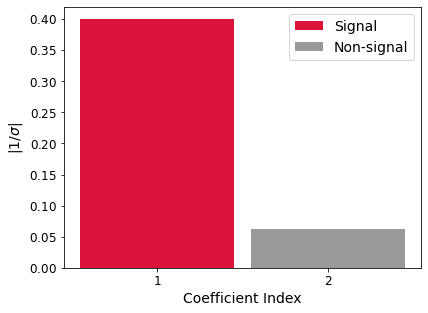

In [33]:
plt.bar(indexes[0], np.abs(bands)[0], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[1], np.abs(bands)[1], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks([1, 2])
plt.legend()
plt.show()

Replicate best_model on different datasets

In [34]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    test_size = 100
    X_test, y_test = jordan_se1(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    val_evaluator = create_supervised_evaluator(best_model, metrics=val_metric, device=device)
    
    # Final evaluation
    val_evaluator.run(test_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

In [35]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-17 14:46:37,990] A new study created in memory with name: no-name-e483ed9d-191b-481a-8609-40e1abbe4340


In [36]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-17 14:46:38,715] Trial 0 finished with value: 0.014248952865600586 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,719] Trial 1 finished with value: 0.03561439990997314 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,723] Trial 2 finished with value: 0.016589140892028807 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,727] Trial 3 finished with value: 0.02212871313095093 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,731] Trial 4 finished with value: 0.019901264905929566 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,735] Trial 5 finished with value: 0.017592545747756958 and parameters: {}. Best is trial 0 with value: 0.014248952865600586.
[I 2022-02-17 14:46:38,739] Trial 6 finished with value: 0.022272605895996094 and parameters: {}. Best is trial 0 

In [37]:
replication.trials_dataframe()['value'].mean()

0.0207922842502594

In [38]:
replication.trials_dataframe()['value'].std()

0.005475633271133959

Predictions on test

In [39]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=2)
    (1): RandomFourierFeaturesLayer(in_features=2, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

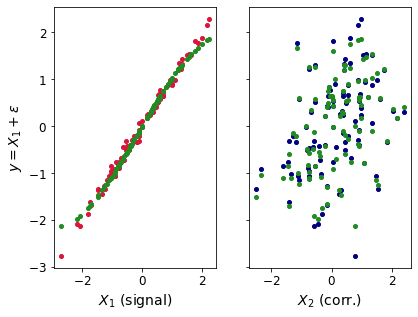

In [40]:
fig,(ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax1.plot(X_test[:, 0], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
ax1.set_xlabel(r"$X_1$ (signal)")
ax1.set_ylabel(r"$y = X_1 + \epsilon$")
ax2.plot(X_test[:, 1], y_test, 'o', markersize=4, color='navy')
ax2.set_xlabel("$X_2$ (corr.)")
ax2.plot(X_test[:, 1], best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.show()

### SE2

In [41]:
n_features = 10

In [42]:
train_size = 300
val_size = 150
test_size = 150

In [43]:
manual_seed(0)

In [44]:
X_se2, y_se2 = jordan_se2(n_samples=600, rho=0.5)

In [45]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se2, y_se2, train_size, val_size, test_size)

Generate datasets

In [46]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val, y_val)

Prepare dataloaders

In [47]:
train_loader = DataLoader(train, batch_size=train_size)
test_loader = DataLoader(test, batch_size=test_size)
val_loader = DataLoader(val, batch_size=val_size)

Objective for optuna

In [48]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 100
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 100
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Optuna callback to save best model

In [49]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

Initalize optuna study

In [50]:
study = optuna.create_study(direction='minimize', pruner=MedianPruner())

[I 2022-02-17 14:46:59,634] A new study created in memory with name: no-name-e5295c8e-bbba-476a-a017-3fd7a35c60d0


Run study

In [51]:
n_epochs = 1050

In [52]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 100 Loss: 21.18063
Validation - Epoch: 100 Loss: 24.41312
Learning rate: 0.0386
Training - Epoch: 200 Loss: 21.07515
Validation - Epoch: 200 Loss: 23.78843
Learning rate: 0.0386
Training - Epoch: 300 Loss: 23.48672
Validation - Epoch: 300 Loss: 25.71375
Learning rate: 0.0386
Training - Epoch: 400 Loss: 19.65550
Validation - Epoch: 400 Loss: 21.87785
Learning rate: 0.0386
Training - Epoch: 500 Loss: 18.40664
Validation - Epoch: 500 Loss: 20.93699
Learning rate: 0.0386
Training - Epoch: 600 Loss: 14.22357
Validation - Epoch: 600 Loss: 17.77345
Learning rate: 0.0193
Training - Epoch: 700 Loss: 13.15952
Validation - Epoch: 700 Loss: 17.08084
Learning rate: 0.0193
Training - Epoch: 800 Loss: 12.21020
Validation - Epoch: 800 Loss: 16.46340
Learning rate: 0.0193
Training - Epoch: 900 Loss: 11.32053
Validation - Epoch: 900 Loss: 15.87491
Learning rate: 0.0193


[I 2022-02-17 14:47:03,936] Trial 0 finished with value: 15.535060221354167 and parameters: {'learning_rate': 0.03860667434626098, 'reg_param': 2.1449601035589753e-06}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 15.16519
Validation - Epoch: 1000 Loss: 19.53660
Learning rate: 0.0193
Training - Epoch: 100 Loss: 34.87882
Validation - Epoch: 100 Loss: 36.42564
Learning rate: 0.0014
Training - Epoch: 200 Loss: 34.69620
Validation - Epoch: 200 Loss: 36.47612
Learning rate: 0.0014
Training - Epoch: 300 Loss: 34.41620
Validation - Epoch: 300 Loss: 36.25788
Learning rate: 0.0014
Training - Epoch: 400 Loss: 33.96886
Validation - Epoch: 400 Loss: 35.73526
Learning rate: 0.0014
Training - Epoch: 500 Loss: 33.43057
Validation - Epoch: 500 Loss: 35.08113
Learning rate: 0.0014
Training - Epoch: 600 Loss: 33.08181
Validation - Epoch: 600 Loss: 34.67480
Learning rate: 0.0007
Training - Epoch: 700 Loss: 32.79695
Validation - Epoch: 700 Loss: 34.35514
Learning rate: 0.0007
Training - Epoch: 800 Loss: 32.51014
Validation - Epoch: 800 Loss: 34.04292
Learning rate: 0.0007
Training - Epoch: 900 Loss: 32.22210
Validation - Epoch: 900 Loss: 33.73742
Learning rate: 0.0007


[I 2022-02-17 14:47:06,314] Trial 1 finished with value: 33.291585286458336 and parameters: {'learning_rate': 0.0013721940005101362, 'reg_param': 0.0004678481112697387}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 31.93340
Validation - Epoch: 1000 Loss: 33.43786
Learning rate: 0.0007
Training - Epoch: 100 Loss: 26.15788
Validation - Epoch: 100 Loss: 28.11303
Learning rate: 0.0206
Training - Epoch: 200 Loss: 21.31820
Validation - Epoch: 200 Loss: 23.39920
Learning rate: 0.0206
Training - Epoch: 300 Loss: 18.62018
Validation - Epoch: 300 Loss: 20.68153
Learning rate: 0.0206
Training - Epoch: 400 Loss: 23.62694
Validation - Epoch: 400 Loss: 25.90820
Learning rate: 0.0206
Training - Epoch: 500 Loss: 23.69071
Validation - Epoch: 500 Loss: 26.05616
Learning rate: 0.0206
Training - Epoch: 600 Loss: 16.05597
Validation - Epoch: 600 Loss: 18.26443
Learning rate: 0.0103
Training - Epoch: 700 Loss: 15.44294
Validation - Epoch: 700 Loss: 17.67749
Learning rate: 0.0103
Training - Epoch: 800 Loss: 14.92620
Validation - Epoch: 800 Loss: 17.18790
Learning rate: 0.0103
Training - Epoch: 900 Loss: 14.48606
Validation - Epoch: 900 Loss: 16.77934
Learning rate: 0.0103


[I 2022-02-17 14:47:08,718] Trial 2 finished with value: 16.286365559895835 and parameters: {'learning_rate': 0.02060312989239586, 'reg_param': 7.801367631292947e-07}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 14.10744
Validation - Epoch: 1000 Loss: 16.43604
Learning rate: 0.0103
Training - Epoch: 100 Loss: 27.99572
Validation - Epoch: 100 Loss: 30.14064
Learning rate: 0.0119
Training - Epoch: 200 Loss: 22.93601
Validation - Epoch: 200 Loss: 25.15868
Learning rate: 0.0119
Training - Epoch: 300 Loss: 19.96176
Validation - Epoch: 300 Loss: 22.18647
Learning rate: 0.0119
Training - Epoch: 400 Loss: 18.06936
Validation - Epoch: 400 Loss: 20.26297
Learning rate: 0.0119
Training - Epoch: 500 Loss: 16.77979
Validation - Epoch: 500 Loss: 18.93150
Learning rate: 0.0119
Training - Epoch: 600 Loss: 16.17123
Validation - Epoch: 600 Loss: 18.29700
Learning rate: 0.0059
Training - Epoch: 700 Loss: 15.75631
Validation - Epoch: 700 Loss: 17.86248
Learning rate: 0.0059
Training - Epoch: 800 Loss: 15.39491
Validation - Epoch: 800 Loss: 17.48311
Learning rate: 0.0059
Training - Epoch: 900 Loss: 15.07719
Validation - Epoch: 900 Loss: 17.14928
Learning rate: 0.0059


[I 2022-02-17 14:47:11,109] Trial 3 finished with value: 16.71921875 and parameters: {'learning_rate': 0.011859369765539468, 'reg_param': 1.0817355143155335e-07}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 14.79553
Validation - Epoch: 1000 Loss: 16.85346
Learning rate: 0.0059
Training - Epoch: 100 Loss: 34.20747
Validation - Epoch: 100 Loss: 35.83843
Learning rate: 0.0018
Training - Epoch: 200 Loss: 32.70704
Validation - Epoch: 200 Loss: 34.61095
Learning rate: 0.0018
Training - Epoch: 300 Loss: 31.35664
Validation - Epoch: 300 Loss: 33.46983
Learning rate: 0.0018
Training - Epoch: 400 Loss: 30.16521
Validation - Epoch: 400 Loss: 32.45556
Learning rate: 0.0018
Training - Epoch: 500 Loss: 29.10695
Validation - Epoch: 500 Loss: 31.54635
Learning rate: 0.0018
Training - Epoch: 600 Loss: 28.50926
Validation - Epoch: 600 Loss: 31.03003
Learning rate: 0.0009
Training - Epoch: 700 Loss: 28.05663
Validation - Epoch: 700 Loss: 30.63798
Learning rate: 0.0009
Training - Epoch: 800 Loss: 27.62824
Validation - Epoch: 800 Loss: 30.26622
Learning rate: 0.0009
Training - Epoch: 900 Loss: 27.22240
Validation - Epoch: 900 Loss: 29.91348
Learning rate: 0.0009


[I 2022-02-17 14:47:13,463] Trial 4 finished with value: 29.418876953125 and parameters: {'learning_rate': 0.0017550804801438067, 'reg_param': 0.009937340932735574}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 26.83755
Validation - Epoch: 1000 Loss: 29.57851
Learning rate: 0.0009
Training - Epoch: 100 Loss: 23.92812
Validation - Epoch: 100 Loss: 27.57589
Learning rate: 0.0438


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:47:13,902] Trial 5 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 22.58241
Training - Epoch: 100 Loss: 25.95258
Validation - Epoch: 100 Loss: 28.48534
Learning rate: 0.0191
Training - Epoch: 200 Loss: 20.86842
Validation - Epoch: 200 Loss: 23.67459
Learning rate: 0.0191
Training - Epoch: 300 Loss: 18.36298
Validation - Epoch: 300 Loss: 21.19134
Learning rate: 0.0191
Training - Epoch: 400 Loss: 19.22332
Validation - Epoch: 400 Loss: 21.68583
Learning rate: 0.0191
Training - Epoch: 500 Loss: 18.68345
Validation - Epoch: 500 Loss: 21.03163
Learning rate: 0.0191


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-17 14:47:15,456] Trial 6 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 16.00091
Training - Epoch: 100 Loss: 23.70226
Validation - Epoch: 100 Loss: 24.59587
Learning rate: 0.0426
Training - Epoch: 200 Loss: 27.81778
Validation - Epoch: 200 Loss: 30.98415
Learning rate: 0.0426
Training - Epoch: 300 Loss: 23.32850
Validation - Epoch: 300 Loss: 26.20035
Learning rate: 0.0426
Training - Epoch: 400 Loss: 18.93992
Validation - Epoch: 400 Loss: 21.37892
Learning rate: 0.0426
Training - Epoch: 500 Loss: 17.15063
Validation - Epoch: 500 Loss: 20.55287
Learning rate: 0.0426
Training - Epoch: 600 Loss: 13.40886
Validation - Epoch: 600 Loss: 17.99650
Learning rate: 0.0213
Training - Epoch: 700 Loss: 12.59292
Validation - Epoch: 700 Loss: 17.52733
Learning rate: 0.0213
Training - Epoch: 800 Loss: 11.84133
Validation - Epoch: 800 Loss: 17.14210
Learning rate: 0.0213
Training - Epoch: 900 Loss: 11.08273
Validation - Epoch: 900 Loss: 16.76962
Learning rate: 0.0213


[I 2022-02-17 14:47:17,954] Trial 7 finished with value: 16.139303385416667 and parameters: {'learning_rate': 0.04261562389003377, 'reg_param': 9.746759883115366e-05}. Best is trial 0 with value: 15.535060221354167.


Training - Epoch: 1000 Loss: 10.28301
Validation - Epoch: 1000 Loss: 16.36187
Learning rate: 0.0213


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:18,195] Trial 8 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 32.53689
Training - Epoch: 100 Loss: 25.47120
Validation - Epoch: 100 Loss: 28.31176
Learning rate: 0.0992
Training - Epoch: 200 Loss: 25.07108
Validation - Epoch: 200 Loss: 27.62672
Learning rate: 0.0992
Training - Epoch: 300 Loss: 17.98876
Validation - Epoch: 300 Loss: 22.44443
Learning rate: 0.0992
Training - Epoch: 400 Loss: 22.92807
Validation - Epoch: 400 Loss: 27.92274
Learning rate: 0.0992
Training - Epoch: 500 Loss: 19.80050
Validation - Epoch: 500 Loss: 26.14630
Learning rate: 0.0992
Training - Epoch: 600 Loss: 14.08995
Validation - Epoch: 600 Loss: 17.27556
Learning rate: 0.0496
Training - Epoch: 700 Loss: 14.35182
Validation - Epoch: 700 Loss: 19.07615
Learning rate: 0.0496
Training - Epoch: 800 Loss: 14.75598
Validation - Epoch: 800 Loss: 19.82519
Learning rate: 0.0496


Engine run is terminating due to exception: Trial was pruned at 900 epoch.
Engine run is terminating due to exception: Trial was pruned at 900 epoch.
[I 2022-02-17 14:47:20,315] Trial 9 pruned. Trial was pruned at 900 epoch.


Training - Epoch: 900 Loss: 14.57354


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:20,543] Trial 10 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 31.93289
Training - Epoch: 100 Loss: 24.05627
Validation - Epoch: 100 Loss: 25.44896
Learning rate: 0.0571
Training - Epoch: 200 Loss: 19.87827
Validation - Epoch: 200 Loss: 22.18883
Learning rate: 0.0571
Training - Epoch: 300 Loss: 17.64768
Validation - Epoch: 300 Loss: 20.13064
Learning rate: 0.0571
Training - Epoch: 400 Loss: 16.73175
Validation - Epoch: 400 Loss: 20.10540
Learning rate: 0.0571
Training - Epoch: 500 Loss: 16.62109
Validation - Epoch: 500 Loss: 20.55848
Learning rate: 0.0571
Training - Epoch: 600 Loss: 11.14496
Validation - Epoch: 600 Loss: 14.73771
Learning rate: 0.0285
Training - Epoch: 700 Loss: 9.25783
Validation - Epoch: 700 Loss: 13.22737
Learning rate: 0.0285
Training - Epoch: 800 Loss: 11.96682
Validation - Epoch: 800 Loss: 16.55473
Learning rate: 0.0285
Training - Epoch: 900 Loss: 11.72524
Validation - Epoch: 900 Loss: 16.36438
Learning rate: 0.0285


[I 2022-02-17 14:47:23,171] Trial 11 finished with value: 11.6976318359375 and parameters: {'learning_rate': 0.05707574914342385, 'reg_param': 3.786624978735453e-06}. Best is trial 11 with value: 11.6976318359375.


Training - Epoch: 1000 Loss: 11.53888
Validation - Epoch: 1000 Loss: 16.22024
Learning rate: 0.0285
Training - Epoch: 100 Loss: 23.74000
Validation - Epoch: 100 Loss: 26.72043
Learning rate: 0.0938


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:47:23,627] Trial 12 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 22.19278
Training - Epoch: 100 Loss: 23.35067
Validation - Epoch: 100 Loss: 24.44856
Learning rate: 0.0459
Training - Epoch: 200 Loss: 22.21632
Validation - Epoch: 200 Loss: 24.25015
Learning rate: 0.0459
Training - Epoch: 300 Loss: 19.87356
Validation - Epoch: 300 Loss: 22.41293
Learning rate: 0.0459
Training - Epoch: 400 Loss: 17.95517
Validation - Epoch: 400 Loss: 21.68423
Learning rate: 0.0459


Engine run is terminating due to exception: Trial was pruned at 500 epoch.
Engine run is terminating due to exception: Trial was pruned at 500 epoch.
[I 2022-02-17 14:47:24,769] Trial 13 pruned. Trial was pruned at 500 epoch.


Training - Epoch: 500 Loss: 19.04405
Training - Epoch: 100 Loss: 21.43434
Validation - Epoch: 100 Loss: 24.22775
Learning rate: 0.0265
Training - Epoch: 200 Loss: 19.18383
Validation - Epoch: 200 Loss: 22.29308
Learning rate: 0.0265
Training - Epoch: 300 Loss: 28.61720
Validation - Epoch: 300 Loss: 31.34068
Learning rate: 0.0265


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-17 14:47:25,738] Trial 14 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 22.43257


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:25,983] Trial 15 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 26.92645


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:26,226] Trial 16 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 28.09391
Training - Epoch: 100 Loss: 23.06601
Validation - Epoch: 100 Loss: 26.23550
Learning rate: 0.0273
Training - Epoch: 200 Loss: 19.09916
Validation - Epoch: 200 Loss: 22.76240
Learning rate: 0.0273
Training - Epoch: 300 Loss: 19.17481
Validation - Epoch: 300 Loss: 21.94388
Learning rate: 0.0273
Training - Epoch: 400 Loss: 18.50129
Validation - Epoch: 400 Loss: 21.04059
Learning rate: 0.0273
Training - Epoch: 500 Loss: 17.98587
Validation - Epoch: 500 Loss: 20.49035
Learning rate: 0.0273
Training - Epoch: 600 Loss: 14.23902
Validation - Epoch: 600 Loss: 17.50953
Learning rate: 0.0137
Training - Epoch: 700 Loss: 13.70651
Validation - Epoch: 700 Loss: 17.02437
Learning rate: 0.0137
Training - Epoch: 800 Loss: 13.27770
Validation - Epoch: 800 Loss: 16.63624
Learning rate: 0.0137
Training - Epoch: 900 Loss: 12.92213
Validation - Epoch: 900 Loss: 16.32316
Learning rate: 0.0137


[I 2022-02-17 14:47:28,654] Trial 17 finished with value: 15.951442057291667 and parameters: {'learning_rate': 0.02731264536093366, 'reg_param': 1.002796496244189e-07}. Best is trial 11 with value: 11.6976318359375.


Training - Epoch: 1000 Loss: 12.61990
Validation - Epoch: 1000 Loss: 16.06422
Learning rate: 0.0137


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:28,903] Trial 18 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 33.14990
Training - Epoch: 100 Loss: 25.15120
Validation - Epoch: 100 Loss: 26.54819
Learning rate: 0.0736


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:47:29,362] Trial 19 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 33.94462
Training - Epoch: 100 Loss: 19.44573
Validation - Epoch: 100 Loss: 21.67760
Learning rate: 0.0314
Training - Epoch: 200 Loss: 23.69224
Validation - Epoch: 200 Loss: 25.98164
Learning rate: 0.0314
Training - Epoch: 300 Loss: 20.39934
Validation - Epoch: 300 Loss: 23.29133
Learning rate: 0.0314


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-17 14:47:30,344] Trial 20 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 21.33896


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:30,580] Trial 21 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.92925
Training - Epoch: 100 Loss: 20.69255
Validation - Epoch: 100 Loss: 23.63395
Learning rate: 0.0316
Training - Epoch: 200 Loss: 22.24614
Validation - Epoch: 200 Loss: 25.84587
Learning rate: 0.0316
Training - Epoch: 300 Loss: 21.17451
Validation - Epoch: 300 Loss: 24.89512
Learning rate: 0.0316


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-17 14:47:31,487] Trial 22 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 19.52157
Training - Epoch: 100 Loss: 22.20874
Validation - Epoch: 100 Loss: 24.34563
Learning rate: 0.0575
Training - Epoch: 200 Loss: 22.32437
Validation - Epoch: 200 Loss: 25.65781
Learning rate: 0.0575
Training - Epoch: 300 Loss: 20.05549
Validation - Epoch: 300 Loss: 21.92403
Learning rate: 0.0575
Training - Epoch: 400 Loss: 16.17708
Validation - Epoch: 400 Loss: 20.27565
Learning rate: 0.0575
Training - Epoch: 500 Loss: 19.89722
Validation - Epoch: 500 Loss: 25.52646
Learning rate: 0.0575
Training - Epoch: 600 Loss: 12.45962
Validation - Epoch: 600 Loss: 17.40965
Learning rate: 0.0287
Training - Epoch: 700 Loss: 10.75650
Validation - Epoch: 700 Loss: 16.01806
Learning rate: 0.0287
Training - Epoch: 800 Loss: 13.46466
Validation - Epoch: 800 Loss: 18.28107
Learning rate: 0.0287
Training - Epoch: 900 Loss: 13.22772
Validation - Epoch: 900 Loss: 18.21818
Learning rate: 0.0287


[I 2022-02-17 14:47:33,893] Trial 23 finished with value: 15.224095052083333 and parameters: {'learning_rate': 0.05747805377026478, 'reg_param': 1.0584020778359746e-05}. Best is trial 11 with value: 11.6976318359375.


Training - Epoch: 1000 Loss: 12.99598
Validation - Epoch: 1000 Loss: 18.17139
Learning rate: 0.0287


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:34,123] Trial 24 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 28.97491


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:34,353] Trial 25 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 26.85824


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:34,610] Trial 26 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 26.18126


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:34,838] Trial 27 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.28078


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:35,161] Trial 28 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.34975


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:35,416] Trial 29 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 34.92230


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:35,661] Trial 30 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 34.73286
Training - Epoch: 100 Loss: 21.23520
Validation - Epoch: 100 Loss: 23.81727
Learning rate: 0.0281
Training - Epoch: 200 Loss: 16.87091
Validation - Epoch: 200 Loss: 19.70193
Learning rate: 0.0281
Training - Epoch: 300 Loss: 18.65708
Validation - Epoch: 300 Loss: 21.42141
Learning rate: 0.0281
Training - Epoch: 400 Loss: 18.22562
Validation - Epoch: 400 Loss: 21.28449
Learning rate: 0.0281
Training - Epoch: 500 Loss: 17.90840
Validation - Epoch: 500 Loss: 21.20728
Learning rate: 0.0281
Training - Epoch: 600 Loss: 13.66133
Validation - Epoch: 600 Loss: 17.66950
Learning rate: 0.0140
Training - Epoch: 700 Loss: 13.16059
Validation - Epoch: 700 Loss: 17.30472
Learning rate: 0.0140
Training - Epoch: 800 Loss: 12.75703
Validation - Epoch: 800 Loss: 17.02317
Learning rate: 0.0140


Engine run is terminating due to exception: Trial was pruned at 900 epoch.
Engine run is terminating due to exception: Trial was pruned at 900 epoch.
[I 2022-02-17 14:47:37,786] Trial 31 pruned. Trial was pruned at 900 epoch.


Training - Epoch: 900 Loss: 12.41994


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:38,022] Trial 32 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.36872
Training - Epoch: 100 Loss: 21.74248
Validation - Epoch: 100 Loss: 22.68538
Learning rate: 0.0362
Training - Epoch: 200 Loss: 21.07844
Validation - Epoch: 200 Loss: 23.27021
Learning rate: 0.0362
Training - Epoch: 300 Loss: 19.40561
Validation - Epoch: 300 Loss: 22.05050
Learning rate: 0.0362
Training - Epoch: 400 Loss: 16.39766
Validation - Epoch: 400 Loss: 20.05993
Learning rate: 0.0362
Training - Epoch: 500 Loss: 27.14450
Validation - Epoch: 500 Loss: 29.62363
Learning rate: 0.0362


Engine run is terminating due to exception: Trial was pruned at 600 epoch.
Engine run is terminating due to exception: Trial was pruned at 600 epoch.
[I 2022-02-17 14:47:39,353] Trial 33 pruned. Trial was pruned at 600 epoch.


Training - Epoch: 600 Loss: 14.51699


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:39,573] Trial 34 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 26.89527


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:39,796] Trial 35 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 31.25870


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:40,075] Trial 36 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.05666


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:40,303] Trial 37 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 25.28260
Training - Epoch: 100 Loss: 21.99900
Validation - Epoch: 100 Loss: 24.14255
Learning rate: 0.0514
Training - Epoch: 200 Loss: 25.26376
Validation - Epoch: 200 Loss: 27.67833
Learning rate: 0.0514
Training - Epoch: 300 Loss: 16.02951
Validation - Epoch: 300 Loss: 19.35058
Learning rate: 0.0514
Training - Epoch: 400 Loss: 17.62499
Validation - Epoch: 400 Loss: 20.80431
Learning rate: 0.0514
Training - Epoch: 500 Loss: 17.32520
Validation - Epoch: 500 Loss: 20.81375
Learning rate: 0.0514
Training - Epoch: 600 Loss: 12.52919
Validation - Epoch: 600 Loss: 16.74888
Learning rate: 0.0257
Training - Epoch: 700 Loss: 10.96298
Validation - Epoch: 700 Loss: 15.63608
Learning rate: 0.0257
Training - Epoch: 800 Loss: 9.63172
Validation - Epoch: 800 Loss: 14.62434
Learning rate: 0.0257
Training - Epoch: 900 Loss: 13.17718
Validation - Epoch: 900 Loss: 18.18189
Learning rate: 0.0257


[I 2022-02-17 14:47:42,669] Trial 38 finished with value: 13.697985026041666 and parameters: {'learning_rate': 0.05137678651913505, 'reg_param': 3.576553835387312e-06}. Best is trial 11 with value: 11.6976318359375.


Training - Epoch: 1000 Loss: 13.13646
Validation - Epoch: 1000 Loss: 18.14093
Learning rate: 0.0257


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:42,895] Trial 39 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 27.72050


Get best model

In [53]:
best_model = study.user_attrs['best_model']

In [54]:
torch.save(best_model.state_dict(), '../models/jordan-se2.pth')

Replicate best_model on different datasets

In [55]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se2(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    val_evaluator = create_supervised_evaluator(best_model, metrics=val_metric, device=device)
    
    # Final evaluation
    val_evaluator.run(test_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

In [56]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-17 14:47:42,929] A new study created in memory with name: no-name-97fb469b-17fe-49f4-a639-a6b79314e790


In [57]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-17 14:47:42,938] Trial 0 finished with value: 11.585608723958334 and parameters: {}. Best is trial 0 with value: 11.585608723958334.
[I 2022-02-17 14:47:42,945] Trial 1 finished with value: 10.852539876302083 and parameters: {}. Best is trial 1 with value: 10.852539876302083.
[I 2022-02-17 14:47:42,952] Trial 2 finished with value: 13.585458170572917 and parameters: {}. Best is trial 1 with value: 10.852539876302083.
[I 2022-02-17 14:47:42,956] Trial 3 finished with value: 8.842162272135417 and parameters: {}. Best is trial 3 with value: 8.842162272135417.
[I 2022-02-17 14:47:42,960] Trial 4 finished with value: 15.0026513671875 and parameters: {}. Best is trial 3 with value: 8.842162272135417.
[I 2022-02-17 14:47:42,967] Trial 5 finished with value: 4.6223050944010415 and parameters: {}. Best is trial 5 with value: 4.6223050944010415.
[I 2022-02-17 14:47:42,973] Trial 6 finished with value: 14.525030924479166 and parameters: {}. Best is trial 5 with value: 4.622305094401041

In [58]:
replication.trials_dataframe()['value'].mean()

15.349770521375866

In [59]:
replication.trials_dataframe()['value'].std()

13.840610384393043

**Visualizing**

Bands

In [60]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

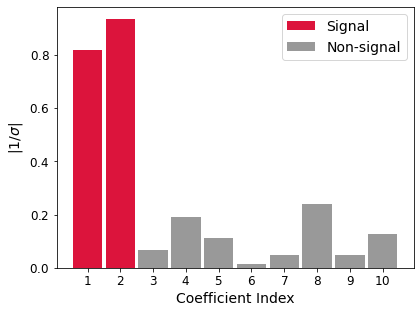

In [61]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

Predictions on test

In [62]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=100)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

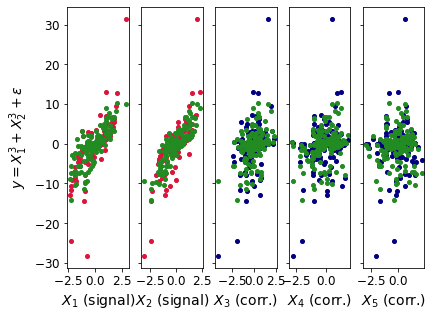

In [63]:
fig, ax = plt.subplots(ncols=5, sharey=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

### SE3

In [64]:
n_features = 10

In [65]:
train_size = 200
val_size = 100
test_size = 100

In [66]:
manual_seed(0)

In [67]:
X_se3, y_se3 = jordan_se3(n_samples=400)

In [68]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se3, y_se3, train_size, val_size, test_size)

Generate datasets

In [69]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val, y_val)

Prepare dataloaders

In [70]:
train_loader = DataLoader(train, batch_size=train_size)
test_loader = DataLoader(test, batch_size=test_size)
val_loader = DataLoader(val, batch_size=val_size)

Objective for optuna

In [71]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 50
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 100
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Optuna callback to save best model

In [72]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

Initalize optuna study

In [73]:
study = optuna.create_study(direction='minimize', pruner=MedianPruner())

[I 2022-02-17 14:47:43,807] A new study created in memory with name: no-name-6e2f64fa-02b7-4ef8-818d-46c8f6d273cc


Run study

In [74]:
n_epochs = 1050

In [75]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 100 Loss: 1.08876
Validation - Epoch: 100 Loss: 0.50711
Learning rate: 0.0028
Training - Epoch: 200 Loss: 1.08369
Validation - Epoch: 200 Loss: 0.50622
Learning rate: 0.0028
Training - Epoch: 300 Loss: 1.07762
Validation - Epoch: 300 Loss: 0.50467
Learning rate: 0.0028
Training - Epoch: 400 Loss: 1.06995
Validation - Epoch: 400 Loss: 0.50251
Learning rate: 0.0028
Training - Epoch: 500 Loss: 1.06064
Validation - Epoch: 500 Loss: 0.49989
Learning rate: 0.0028
Training - Epoch: 600 Loss: 1.05420
Validation - Epoch: 600 Loss: 0.49814
Learning rate: 0.0014
Training - Epoch: 700 Loss: 1.04877
Validation - Epoch: 700 Loss: 0.49670
Learning rate: 0.0014
Training - Epoch: 800 Loss: 1.04323
Validation - Epoch: 800 Loss: 0.49530
Learning rate: 0.0014
Training - Epoch: 900 Loss: 1.03767
Validation - Epoch: 900 Loss: 0.49396
Learning rate: 0.0014
Training - Epoch: 1000 Loss: 1.03218
Validation - Epoch: 1000 Loss: 0.49271
Learning rate: 0.0014


[I 2022-02-17 14:47:45,827] Trial 0 finished with value: 0.4921394729614258 and parameters: {'learning_rate': 0.0028281653278476294, 'reg_param': 6.77676277457141e-06}. Best is trial 0 with value: 0.4921394729614258.


Training - Epoch: 100 Loss: 1.09404
Validation - Epoch: 100 Loss: 0.51182
Learning rate: 0.0010
Training - Epoch: 200 Loss: 1.09377
Validation - Epoch: 200 Loss: 0.51168
Learning rate: 0.0010
Training - Epoch: 300 Loss: 1.09352
Validation - Epoch: 300 Loss: 0.51160
Learning rate: 0.0010
Training - Epoch: 400 Loss: 1.09327
Validation - Epoch: 400 Loss: 0.51156
Learning rate: 0.0010
Training - Epoch: 500 Loss: 1.09304
Validation - Epoch: 500 Loss: 0.51154
Learning rate: 0.0010
Training - Epoch: 600 Loss: 1.09289
Validation - Epoch: 600 Loss: 0.51154
Learning rate: 0.0005
Training - Epoch: 700 Loss: 1.09277
Validation - Epoch: 700 Loss: 0.51155
Learning rate: 0.0005
Training - Epoch: 800 Loss: 1.09266
Validation - Epoch: 800 Loss: 0.51156
Learning rate: 0.0005
Training - Epoch: 900 Loss: 1.09254
Validation - Epoch: 900 Loss: 0.51157
Learning rate: 0.0005
Training - Epoch: 1000 Loss: 1.09243
Validation - Epoch: 1000 Loss: 0.51158
Learning rate: 0.0005


[I 2022-02-17 14:47:47,803] Trial 1 finished with value: 0.5115866851806641 and parameters: {'learning_rate': 0.001026902789987956, 'reg_param': 0.006164830757454751}. Best is trial 0 with value: 0.4921394729614258.


Training - Epoch: 100 Loss: 1.09513
Validation - Epoch: 100 Loss: 0.50863
Learning rate: 0.0026
Training - Epoch: 200 Loss: 1.09186
Validation - Epoch: 200 Loss: 0.50837
Learning rate: 0.0026
Training - Epoch: 300 Loss: 1.09099
Validation - Epoch: 300 Loss: 0.50889
Learning rate: 0.0026
Training - Epoch: 400 Loss: 1.09038
Validation - Epoch: 400 Loss: 0.50912
Learning rate: 0.0026
Training - Epoch: 500 Loss: 1.08973
Validation - Epoch: 500 Loss: 0.50915
Learning rate: 0.0026
Training - Epoch: 600 Loss: 1.08927
Validation - Epoch: 600 Loss: 0.50912
Learning rate: 0.0013
Training - Epoch: 700 Loss: 1.08887
Validation - Epoch: 700 Loss: 0.50906
Learning rate: 0.0013
Training - Epoch: 800 Loss: 1.08842
Validation - Epoch: 800 Loss: 0.50898
Learning rate: 0.0013
Training - Epoch: 900 Loss: 1.08791
Validation - Epoch: 900 Loss: 0.50889
Learning rate: 0.0013


[I 2022-02-17 14:47:49,752] Trial 2 finished with value: 0.5086948776245117 and parameters: {'learning_rate': 0.0025944562921678916, 'reg_param': 3.901296617267932e-06}. Best is trial 0 with value: 0.4921394729614258.


Training - Epoch: 1000 Loss: 1.08735
Validation - Epoch: 1000 Loss: 0.50876
Learning rate: 0.0013
Training - Epoch: 100 Loss: 1.09104
Validation - Epoch: 100 Loss: 0.50866
Learning rate: 0.0026
Training - Epoch: 200 Loss: 1.08944
Validation - Epoch: 200 Loss: 0.50838
Learning rate: 0.0026
Training - Epoch: 300 Loss: 1.08758
Validation - Epoch: 300 Loss: 0.50789
Learning rate: 0.0026
Training - Epoch: 400 Loss: 1.08533
Validation - Epoch: 400 Loss: 0.50723
Learning rate: 0.0026
Training - Epoch: 500 Loss: 1.08255
Validation - Epoch: 500 Loss: 0.50641
Learning rate: 0.0026
Training - Epoch: 600 Loss: 1.08051
Validation - Epoch: 600 Loss: 0.50580
Learning rate: 0.0013
Training - Epoch: 700 Loss: 1.07867
Validation - Epoch: 700 Loss: 0.50525
Learning rate: 0.0013
Training - Epoch: 800 Loss: 1.07666
Validation - Epoch: 800 Loss: 0.50466
Learning rate: 0.0013
Training - Epoch: 900 Loss: 1.07446
Validation - Epoch: 900 Loss: 0.50402
Learning rate: 0.0013


[I 2022-02-17 14:47:51,708] Trial 3 finished with value: 0.5029835510253906 and parameters: {'learning_rate': 0.0025994052388166617, 'reg_param': 1.0748209491421223e-06}. Best is trial 0 with value: 0.4921394729614258.


Training - Epoch: 1000 Loss: 1.07209
Validation - Epoch: 1000 Loss: 0.50334
Learning rate: 0.0013
Training - Epoch: 100 Loss: 1.09182
Validation - Epoch: 100 Loss: 0.50938
Learning rate: 0.0089
Training - Epoch: 200 Loss: 1.09029
Validation - Epoch: 200 Loss: 0.50900
Learning rate: 0.0089
Training - Epoch: 300 Loss: 1.08537
Validation - Epoch: 300 Loss: 0.50755
Learning rate: 0.0089
Training - Epoch: 400 Loss: 1.07025
Validation - Epoch: 400 Loss: 0.50332
Learning rate: 0.0089
Training - Epoch: 500 Loss: 1.04057
Validation - Epoch: 500 Loss: 0.49720
Learning rate: 0.0089
Training - Epoch: 600 Loss: 1.02109
Validation - Epoch: 600 Loss: 0.49579
Learning rate: 0.0044
Training - Epoch: 700 Loss: 1.00782
Validation - Epoch: 700 Loss: 0.49676
Learning rate: 0.0044
Training - Epoch: 800 Loss: 0.99667
Validation - Epoch: 800 Loss: 0.49907
Learning rate: 0.0044
Training - Epoch: 900 Loss: 0.98690
Validation - Epoch: 900 Loss: 0.50211
Learning rate: 0.0044
Training - Epoch: 1000 Loss: 0.97783
V

[I 2022-02-17 14:47:53,712] Trial 4 finished with value: 0.5071033096313476 and parameters: {'learning_rate': 0.008896179687628642, 'reg_param': 0.00014556355345976313}. Best is trial 0 with value: 0.4921394729614258.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:53,899] Trial 5 pruned. Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:47:54,088] Trial 6 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.11676
Training - Epoch: 100 Loss: 1.09237
Training - Epoch: 100 Loss: 1.07095
Validation - Epoch: 100 Loss: 0.50291
Learning rate: 0.0387
Training - Epoch: 200 Loss: 0.98863
Validation - Epoch: 200 Loss: 0.49607
Learning rate: 0.0387
Training - Epoch: 300 Loss: 0.89173
Validation - Epoch: 300 Loss: 0.47208
Learning rate: 0.0387
Training - Epoch: 400 Loss: 0.65052
Validation - Epoch: 400 Loss: 0.31787
Learning rate: 0.0387
Training - Epoch: 500 Loss: 0.46359
Validation - Epoch: 500 Loss: 0.20699
Learning rate: 0.0387
Training - Epoch: 600 Loss: 0.38968
Validation - Epoch: 600 Loss: 0.17226
Learning rate: 0.0194
Training - Epoch: 700 Loss: 0.34459
Validation - Epoch: 700 Loss: 0.15364
Learning rate: 0.0194
Training - Epoch: 800 Loss: 0.30842
Validation - Epoch: 800 Loss: 0.14002
Learning rate: 0.0194
Training - Epoch: 900 Loss: 0.27884
Validation - Epoch: 900 Loss: 0.12973
Learning rate: 0.0194
Training - Epoch: 1000 Loss: 0.25427
Validation - Epoch: 1000 Lo

[I 2022-02-17 14:47:56,091] Trial 7 finished with value: 0.11846585273742676 and parameters: {'learning_rate': 0.03874940056246955, 'reg_param': 0.0004767545075980229}. Best is trial 7 with value: 0.11846585273742676.


Training - Epoch: 100 Loss: 1.07788
Validation - Epoch: 100 Loss: 0.50666
Learning rate: 0.0309
Training - Epoch: 200 Loss: 1.00191
Validation - Epoch: 200 Loss: 0.49746
Learning rate: 0.0309
Training - Epoch: 300 Loss: 0.95405
Validation - Epoch: 300 Loss: 0.49925
Learning rate: 0.0309
Training - Epoch: 400 Loss: 0.86029
Validation - Epoch: 400 Loss: 0.45308
Learning rate: 0.0309
Training - Epoch: 500 Loss: 0.72382
Validation - Epoch: 500 Loss: 0.36342
Learning rate: 0.0309
Training - Epoch: 600 Loss: 0.63596
Validation - Epoch: 600 Loss: 0.30006
Learning rate: 0.0154
Training - Epoch: 700 Loss: 0.57010
Validation - Epoch: 700 Loss: 0.25364
Learning rate: 0.0154
Training - Epoch: 800 Loss: 0.51167
Validation - Epoch: 800 Loss: 0.21479
Learning rate: 0.0154
Training - Epoch: 900 Loss: 0.46102
Validation - Epoch: 900 Loss: 0.18329
Learning rate: 0.0154


[I 2022-02-17 14:47:58,139] Trial 8 finished with value: 0.14672322273254396 and parameters: {'learning_rate': 0.030899854785505894, 'reg_param': 1.2966291041805475e-06}. Best is trial 7 with value: 0.11846585273742676.


Training - Epoch: 1000 Loss: 0.41715
Validation - Epoch: 1000 Loss: 0.15767
Learning rate: 0.0154
Training - Epoch: 100 Loss: 0.84908
Validation - Epoch: 100 Loss: 0.43654
Learning rate: 0.0744
Training - Epoch: 200 Loss: 0.30845
Validation - Epoch: 200 Loss: 0.11232
Learning rate: 0.0744
Training - Epoch: 300 Loss: 0.16414
Validation - Epoch: 300 Loss: 0.05022
Learning rate: 0.0744
Training - Epoch: 400 Loss: 0.11093
Validation - Epoch: 400 Loss: 0.03661
Learning rate: 0.0744
Training - Epoch: 500 Loss: 0.08549
Validation - Epoch: 500 Loss: 0.03257
Learning rate: 0.0744
Training - Epoch: 600 Loss: 0.07570
Validation - Epoch: 600 Loss: 0.03140
Learning rate: 0.0372
Training - Epoch: 700 Loss: 0.06969
Validation - Epoch: 700 Loss: 0.03076
Learning rate: 0.0372
Training - Epoch: 800 Loss: 0.06484
Validation - Epoch: 800 Loss: 0.03026
Learning rate: 0.0372
Training - Epoch: 900 Loss: 0.06085
Validation - Epoch: 900 Loss: 0.02986
Learning rate: 0.0372


[I 2022-02-17 14:48:00,634] Trial 9 finished with value: 0.029367516040802 and parameters: {'learning_rate': 0.07438198534242195, 'reg_param': 2.2083453860304582e-06}. Best is trial 9 with value: 0.029367516040802.


Training - Epoch: 1000 Loss: 0.05750
Validation - Epoch: 1000 Loss: 0.02952
Learning rate: 0.0372
Training - Epoch: 100 Loss: 0.93827
Validation - Epoch: 100 Loss: 0.50216
Learning rate: 0.0877
Training - Epoch: 200 Loss: 0.43036
Validation - Epoch: 200 Loss: 0.21719
Learning rate: 0.0877
Training - Epoch: 300 Loss: 0.22537
Validation - Epoch: 300 Loss: 0.10238
Learning rate: 0.0877
Training - Epoch: 400 Loss: 0.14897
Validation - Epoch: 400 Loss: 0.07379
Learning rate: 0.0877
Training - Epoch: 500 Loss: 0.11230
Validation - Epoch: 500 Loss: 0.06398
Learning rate: 0.0877
Training - Epoch: 600 Loss: 0.09824
Validation - Epoch: 600 Loss: 0.06086
Learning rate: 0.0438
Training - Epoch: 700 Loss: 0.08964
Validation - Epoch: 700 Loss: 0.05906
Learning rate: 0.0438
Training - Epoch: 800 Loss: 0.08273
Validation - Epoch: 800 Loss: 0.05762
Learning rate: 0.0438
Training - Epoch: 900 Loss: 0.07706
Validation - Epoch: 900 Loss: 0.05641
Learning rate: 0.0438


[I 2022-02-17 14:48:03,099] Trial 10 finished with value: 0.05486593246459961 and parameters: {'learning_rate': 0.08766072895523584, 'reg_param': 1.0930301697073643e-07}. Best is trial 9 with value: 0.029367516040802.


Training - Epoch: 1000 Loss: 0.07232
Validation - Epoch: 1000 Loss: 0.05535
Learning rate: 0.0438
Training - Epoch: 100 Loss: 0.76108
Validation - Epoch: 100 Loss: 0.38381
Learning rate: 0.0778
Training - Epoch: 200 Loss: 0.34051
Validation - Epoch: 200 Loss: 0.14567
Learning rate: 0.0778
Training - Epoch: 300 Loss: 0.18083
Validation - Epoch: 300 Loss: 0.06212
Learning rate: 0.0778
Training - Epoch: 400 Loss: 0.11372
Validation - Epoch: 400 Loss: 0.03547
Learning rate: 0.0778
Training - Epoch: 500 Loss: 0.08113
Validation - Epoch: 500 Loss: 0.02678
Learning rate: 0.0778
Training - Epoch: 600 Loss: 0.06887
Validation - Epoch: 600 Loss: 0.02450
Learning rate: 0.0389
Training - Epoch: 700 Loss: 0.06152
Validation - Epoch: 700 Loss: 0.02342
Learning rate: 0.0389
Training - Epoch: 800 Loss: 0.05575
Validation - Epoch: 800 Loss: 0.02272
Learning rate: 0.0389
Training - Epoch: 900 Loss: 0.05113
Validation - Epoch: 900 Loss: 0.02224
Learning rate: 0.0389


[I 2022-02-17 14:48:05,465] Trial 11 finished with value: 0.021774184703826905 and parameters: {'learning_rate': 0.0777825767021358, 'reg_param': 1.1512683566207422e-07}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.04737
Validation - Epoch: 1000 Loss: 0.02190
Learning rate: 0.0389
Training - Epoch: 100 Loss: 0.89139
Validation - Epoch: 100 Loss: 0.48118
Learning rate: 0.0955
Training - Epoch: 200 Loss: 0.45748
Validation - Epoch: 200 Loss: 0.23917
Learning rate: 0.0955
Training - Epoch: 300 Loss: 0.28562
Validation - Epoch: 300 Loss: 0.15275
Learning rate: 0.0955
Training - Epoch: 400 Loss: 0.21651
Validation - Epoch: 400 Loss: 0.12157
Learning rate: 0.0955
Training - Epoch: 500 Loss: 0.17884
Validation - Epoch: 500 Loss: 0.10530
Learning rate: 0.0955
Training - Epoch: 600 Loss: 0.16183
Validation - Epoch: 600 Loss: 0.09799
Learning rate: 0.0478
Training - Epoch: 700 Loss: 0.14984
Validation - Epoch: 700 Loss: 0.09279
Learning rate: 0.0478
Training - Epoch: 800 Loss: 0.13868
Validation - Epoch: 800 Loss: 0.08785
Learning rate: 0.0478
Training - Epoch: 900 Loss: 0.12794
Validation - Epoch: 900 Loss: 0.08291
Learning rate: 0.0478


[I 2022-02-17 14:48:07,721] Trial 12 finished with value: 0.07500113010406494 and parameters: {'learning_rate': 0.09550767217068493, 'reg_param': 2.0049974225846868e-07}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.11737
Validation - Epoch: 1000 Loss: 0.07772
Learning rate: 0.0478
Training - Epoch: 100 Loss: 1.06587
Validation - Epoch: 100 Loss: 0.49876
Learning rate: 0.0332
Training - Epoch: 200 Loss: 0.94502
Validation - Epoch: 200 Loss: 0.46041
Learning rate: 0.0332
Training - Epoch: 300 Loss: 0.75039
Validation - Epoch: 300 Loss: 0.35808
Learning rate: 0.0332
Training - Epoch: 400 Loss: 0.60721
Validation - Epoch: 400 Loss: 0.27611
Learning rate: 0.0332
Training - Epoch: 500 Loss: 0.49872
Validation - Epoch: 500 Loss: 0.20761
Learning rate: 0.0332
Training - Epoch: 600 Loss: 0.44265
Validation - Epoch: 600 Loss: 0.17083
Learning rate: 0.0166
Training - Epoch: 700 Loss: 0.40250
Validation - Epoch: 700 Loss: 0.14507
Learning rate: 0.0166
Training - Epoch: 800 Loss: 0.36651
Validation - Epoch: 800 Loss: 0.12316
Learning rate: 0.0166
Training - Epoch: 900 Loss: 0.33439
Validation - Epoch: 900 Loss: 0.10510
Learning rate: 0.0166


[I 2022-02-17 14:48:10,082] Trial 13 finished with value: 0.08453370094299316 and parameters: {'learning_rate': 0.033182482010975595, 'reg_param': 3.324500245755249e-07}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.30583
Validation - Epoch: 1000 Loss: 0.09057
Learning rate: 0.0166
Training - Epoch: 100 Loss: 1.07405
Validation - Epoch: 100 Loss: 0.50284
Learning rate: 0.0161
Training - Epoch: 200 Loss: 1.02431
Validation - Epoch: 200 Loss: 0.49004
Learning rate: 0.0161


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-17 14:48:10,784] Trial 14 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.98644


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:48:11,204] Trial 15 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 100 Loss: 1.00326
Validation - Epoch: 100 Loss: 0.49815
Learning rate: 0.0442
Training - Epoch: 200 Loss: 0.93927


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:11,397] Trial 16 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.09022
Training - Epoch: 100 Loss: 0.91480
Validation - Epoch: 100 Loss: 0.43431
Learning rate: 0.0649
Training - Epoch: 200 Loss: 0.47813
Validation - Epoch: 200 Loss: 0.18338
Learning rate: 0.0649
Training - Epoch: 300 Loss: 0.28443
Validation - Epoch: 300 Loss: 0.09283
Learning rate: 0.0649
Training - Epoch: 400 Loss: 0.19664
Validation - Epoch: 400 Loss: 0.06207
Learning rate: 0.0649
Training - Epoch: 500 Loss: 0.14976
Validation - Epoch: 500 Loss: 0.04794
Learning rate: 0.0649
Training - Epoch: 600 Loss: 0.13073
Validation - Epoch: 600 Loss: 0.04262
Learning rate: 0.0324
Training - Epoch: 700 Loss: 0.11878
Validation - Epoch: 700 Loss: 0.03942
Learning rate: 0.0324
Training - Epoch: 800 Loss: 0.10902
Validation - Epoch: 800 Loss: 0.03688
Learning rate: 0.0324
Training - Epoch: 900 Loss: 0.10092
Validation - Epoch: 900 Loss: 0.03485
Learning rate: 0.0324


[I 2022-02-17 14:48:13,842] Trial 17 finished with value: 0.03248147010803223 and parameters: {'learning_rate': 0.06488738123644659, 'reg_param': 2.650212953381657e-05}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.09410
Validation - Epoch: 1000 Loss: 0.03319
Learning rate: 0.0324


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:14,143] Trial 18 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.08741


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:14,371] Trial 19 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.08745
Training - Epoch: 100 Loss: 1.02721
Validation - Epoch: 100 Loss: 0.49220
Learning rate: 0.0558
Training - Epoch: 200 Loss: 0.74063
Validation - Epoch: 200 Loss: 0.35245
Learning rate: 0.0558
Training - Epoch: 300 Loss: 0.40954
Validation - Epoch: 300 Loss: 0.16562
Learning rate: 0.0558
Training - Epoch: 400 Loss: 0.26873
Validation - Epoch: 400 Loss: 0.10314
Learning rate: 0.0558
Training - Epoch: 500 Loss: 0.20124
Validation - Epoch: 500 Loss: 0.07922
Learning rate: 0.0558
Training - Epoch: 600 Loss: 0.17638
Validation - Epoch: 600 Loss: 0.07229
Learning rate: 0.0279
Training - Epoch: 700 Loss: 0.16173
Validation - Epoch: 700 Loss: 0.06891
Learning rate: 0.0279
Training - Epoch: 800 Loss: 0.15038
Validation - Epoch: 800 Loss: 0.06675
Learning rate: 0.0279
Training - Epoch: 900 Loss: 0.14141
Validation - Epoch: 900 Loss: 0.06540
Learning rate: 0.0279


[I 2022-02-17 14:48:16,451] Trial 20 finished with value: 0.06430533409118652 and parameters: {'learning_rate': 0.05584921902594389, 'reg_param': 0.0010519076854737768}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.13422
Validation - Epoch: 1000 Loss: 0.06457
Learning rate: 0.0279
Training - Epoch: 100 Loss: 1.03871
Validation - Epoch: 100 Loss: 0.49040
Learning rate: 0.0567
Training - Epoch: 200 Loss: 0.57480
Validation - Epoch: 200 Loss: 0.24016
Learning rate: 0.0567
Training - Epoch: 300 Loss: 0.32007
Validation - Epoch: 300 Loss: 0.11413
Learning rate: 0.0567
Training - Epoch: 400 Loss: 0.20612
Validation - Epoch: 400 Loss: 0.07026
Learning rate: 0.0567
Training - Epoch: 500 Loss: 0.14830
Validation - Epoch: 500 Loss: 0.05462
Learning rate: 0.0567
Training - Epoch: 600 Loss: 0.12602
Validation - Epoch: 600 Loss: 0.05032
Learning rate: 0.0283
Training - Epoch: 700 Loss: 0.11251
Validation - Epoch: 700 Loss: 0.04820
Learning rate: 0.0283
Training - Epoch: 800 Loss: 0.10179
Validation - Epoch: 800 Loss: 0.04677
Learning rate: 0.0283
Training - Epoch: 900 Loss: 0.09311
Validation - Epoch: 900 Loss: 0.04574
Learning rate: 0.0283
Training - Epoch: 1000 Loss: 0.08598
V

[I 2022-02-17 14:48:18,511] Trial 21 finished with value: 0.04463448047637939 and parameters: {'learning_rate': 0.05669605882502769, 'reg_param': 2.1596795929704026e-05}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 100 Loss: 1.03262
Validation - Epoch: 100 Loss: 0.49925
Learning rate: 0.0749
Training - Epoch: 200 Loss: 0.79204
Validation - Epoch: 200 Loss: 0.44390
Learning rate: 0.0749
Training - Epoch: 300 Loss: 0.37402
Validation - Epoch: 300 Loss: 0.14953
Learning rate: 0.0749
Training - Epoch: 400 Loss: 0.21085
Validation - Epoch: 400 Loss: 0.06914
Learning rate: 0.0749
Training - Epoch: 500 Loss: 0.14449
Validation - Epoch: 500 Loss: 0.04951
Learning rate: 0.0749
Training - Epoch: 600 Loss: 0.12165
Validation - Epoch: 600 Loss: 0.04467
Learning rate: 0.0375
Training - Epoch: 700 Loss: 0.10843
Validation - Epoch: 700 Loss: 0.04228
Learning rate: 0.0375
Training - Epoch: 800 Loss: 0.09820
Validation - Epoch: 800 Loss: 0.04062
Learning rate: 0.0375
Training - Epoch: 900 Loss: 0.09009
Validation - Epoch: 900 Loss: 0.03940
Learning rate: 0.0375


[I 2022-02-17 14:48:20,664] Trial 22 finished with value: 0.038058195114135746 and parameters: {'learning_rate': 0.07492074711073848, 'reg_param': 3.482767995841804e-05}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.08349
Validation - Epoch: 1000 Loss: 0.03845
Learning rate: 0.0375
Training - Epoch: 100 Loss: 1.06629
Validation - Epoch: 100 Loss: 0.49999
Learning rate: 0.0262


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:48:21,182] Trial 23 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 0.98986


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:48:21,563] Trial 24 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 100 Loss: 1.04750
Validation - Epoch: 100 Loss: 0.49592
Learning rate: 0.0610
Training - Epoch: 200 Loss: 0.94498


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:21,755] Trial 25 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.91790
Training - Epoch: 100 Loss: 0.98905
Validation - Epoch: 100 Loss: 0.49494
Learning rate: 0.0492
Training - Epoch: 200 Loss: 0.66599
Validation - Epoch: 200 Loss: 0.31506
Learning rate: 0.0492
Training - Epoch: 300 Loss: 0.38921
Validation - Epoch: 300 Loss: 0.15311
Learning rate: 0.0492
Training - Epoch: 400 Loss: 0.25036
Validation - Epoch: 400 Loss: 0.08605
Learning rate: 0.0492
Training - Epoch: 500 Loss: 0.17899
Validation - Epoch: 500 Loss: 0.05823
Learning rate: 0.0492
Training - Epoch: 600 Loss: 0.15169
Validation - Epoch: 600 Loss: 0.04950
Learning rate: 0.0246
Training - Epoch: 700 Loss: 0.13524
Validation - Epoch: 700 Loss: 0.04490
Learning rate: 0.0246
Training - Epoch: 800 Loss: 0.12225
Validation - Epoch: 800 Loss: 0.04166
Learning rate: 0.0246
Training - Epoch: 900 Loss: 0.11179
Validation - Epoch: 900 Loss: 0.03932
Learning rate: 0.0246
Training - Epoch: 1000 Loss: 0.10321
Validation - Epoch: 1000 Loss: 0.03759
Learning rate: 0.0246


[I 2022-02-17 14:48:23,776] Trial 26 finished with value: 0.03689927577972412 and parameters: {'learning_rate': 0.04916026277819842, 'reg_param': 4.082256234884559e-07}. Best is trial 11 with value: 0.021774184703826905.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:23,966] Trial 27 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 0.97458


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-17 14:48:24,347] Trial 28 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 100 Loss: 1.04120
Validation - Epoch: 100 Loss: 0.49579
Learning rate: 0.0259
Training - Epoch: 200 Loss: 0.96369


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:24,541] Trial 29 pruned. Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:24,737] Trial 30 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.09103
Training - Epoch: 100 Loss: 1.08422
Training - Epoch: 100 Loss: 1.04457
Validation - Epoch: 100 Loss: 0.49197
Learning rate: 0.0428


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-17 14:48:25,400] Trial 31 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 200 Loss: 0.89404
Validation - Epoch: 200 Loss: 0.42319
Learning rate: 0.0428
Training - Epoch: 300 Loss: 0.58271


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:25,590] Trial 32 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.08175
Training - Epoch: 100 Loss: 0.99422
Validation - Epoch: 100 Loss: 0.49079
Learning rate: 0.0688
Training - Epoch: 200 Loss: 0.63440
Validation - Epoch: 200 Loss: 0.29511
Learning rate: 0.0688
Training - Epoch: 300 Loss: 0.38145
Validation - Epoch: 300 Loss: 0.13736
Learning rate: 0.0688
Training - Epoch: 400 Loss: 0.25318
Validation - Epoch: 400 Loss: 0.08057
Learning rate: 0.0688
Training - Epoch: 500 Loss: 0.18451
Validation - Epoch: 500 Loss: 0.06127
Learning rate: 0.0688
Training - Epoch: 600 Loss: 0.15731
Validation - Epoch: 600 Loss: 0.05621
Learning rate: 0.0344
Training - Epoch: 700 Loss: 0.14060
Validation - Epoch: 700 Loss: 0.05388
Learning rate: 0.0344
Training - Epoch: 800 Loss: 0.12722
Validation - Epoch: 800 Loss: 0.05244
Learning rate: 0.0344
Training - Epoch: 900 Loss: 0.11631
Validation - Epoch: 900 Loss: 0.05154
Learning rate: 0.0344
Training - Epoch: 1000 Loss: 0.10730
Validation - Epoch: 1000 Loss: 0.05096
Learning rate: 0.0344


[I 2022-02-17 14:48:27,681] Trial 33 finished with value: 0.05074483394622803 and parameters: {'learning_rate': 0.06876945890196523, 'reg_param': 2.73479740317393e-07}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 100 Loss: 1.03931
Validation - Epoch: 100 Loss: 0.49584
Learning rate: 0.0807
Training - Epoch: 200 Loss: 0.49319
Validation - Epoch: 200 Loss: 0.16320
Learning rate: 0.0807
Training - Epoch: 300 Loss: 0.25324
Validation - Epoch: 300 Loss: 0.06169
Learning rate: 0.0807
Training - Epoch: 400 Loss: 0.16222
Validation - Epoch: 400 Loss: 0.03992
Learning rate: 0.0807
Training - Epoch: 500 Loss: 0.11974
Validation - Epoch: 500 Loss: 0.03435
Learning rate: 0.0807
Training - Epoch: 600 Loss: 0.10376
Validation - Epoch: 600 Loss: 0.03295
Learning rate: 0.0404
Training - Epoch: 700 Loss: 0.09407
Validation - Epoch: 700 Loss: 0.03223
Learning rate: 0.0404
Training - Epoch: 800 Loss: 0.08634
Validation - Epoch: 800 Loss: 0.03170
Learning rate: 0.0404
Training - Epoch: 900 Loss: 0.08002
Validation - Epoch: 900 Loss: 0.03129
Learning rate: 0.0404


[I 2022-02-17 14:48:29,710] Trial 34 finished with value: 0.030786640644073486 and parameters: {'learning_rate': 0.08073541976122937, 'reg_param': 8.751613997187137e-07}. Best is trial 11 with value: 0.021774184703826905.


Training - Epoch: 1000 Loss: 0.07477
Validation - Epoch: 1000 Loss: 0.03094
Learning rate: 0.0404
Training - Epoch: 100 Loss: 0.99873
Validation - Epoch: 100 Loss: 0.49554
Learning rate: 0.0761
Training - Epoch: 200 Loss: 0.58272
Validation - Epoch: 200 Loss: 0.25017
Learning rate: 0.0761


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-17 14:48:30,461] Trial 35 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 300 Loss: 0.34332
Validation - Epoch: 300 Loss: 0.13347
Learning rate: 0.0761
Training - Epoch: 400 Loss: 0.26526
Training - Epoch: 100 Loss: 0.67733
Validation - Epoch: 100 Loss: 0.34445
Learning rate: 0.0997
Training - Epoch: 200 Loss: 0.29598
Validation - Epoch: 200 Loss: 0.11929
Learning rate: 0.0997
Training - Epoch: 300 Loss: 0.16023
Validation - Epoch: 300 Loss: 0.06151
Learning rate: 0.0997
Training - Epoch: 400 Loss: 0.10899
Validation - Epoch: 400 Loss: 0.04880
Learning rate: 0.0997
Training - Epoch: 500 Loss: 0.08455
Validation - Epoch: 500 Loss: 0.04375
Learning rate: 0.0997
Training - Epoch: 600 Loss: 0.07509
Validation - Epoch: 600 Loss: 0.04155
Learning rate: 0.0498
Training - Epoch: 700 Loss: 0.06923
Validation - Epoch: 700 Loss: 0.04003
Learning rate: 0.0498
Training - Epoch: 800 Loss: 0.06447
Validation - Epoch: 800 Loss: 0.03869
Learning rate: 0.0498
Training - Epoch: 900 Loss: 0.06053
Validation - Epoch: 900 Loss: 0.03748
Learning rate: 0.0498
Trai

[I 2022-02-17 14:48:32,585] Trial 36 finished with value: 0.0358926248550415 and parameters: {'learning_rate': 0.09969821707142709, 'reg_param': 8.943818567271353e-07}. Best is trial 11 with value: 0.021774184703826905.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:32,794] Trial 37 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.09178


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:33,034] Trial 38 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.09347


Engine run is terminating due to exception: Trial was pruned at 100 epoch.
Engine run is terminating due to exception: Trial was pruned at 100 epoch.
[I 2022-02-17 14:48:33,268] Trial 39 pruned. Trial was pruned at 100 epoch.


Training - Epoch: 100 Loss: 1.06695


Get best model

In [76]:
best_model = study.user_attrs['best_model']

In [77]:
torch.save(best_model.state_dict(), '../models/jordan-se3.pth')

Replicate best_model on different datasets

In [78]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se3(n_samples=test_size)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    val_evaluator = create_supervised_evaluator(best_model, metrics=val_metric, device=device)
    
    # Final evaluation
    val_evaluator.run(test_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

In [79]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-17 14:48:33,302] A new study created in memory with name: no-name-bb5cb62f-19fc-40ce-b529-54baad8ec51a


In [80]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-17 14:48:33,311] Trial 0 finished with value: 0.07247913837432861 and parameters: {}. Best is trial 0 with value: 0.07247913837432861.
[I 2022-02-17 14:48:33,314] Trial 1 finished with value: 0.1093587875366211 and parameters: {}. Best is trial 0 with value: 0.07247913837432861.
[I 2022-02-17 14:48:33,317] Trial 2 finished with value: 0.059335360527038576 and parameters: {}. Best is trial 2 with value: 0.059335360527038576.
[I 2022-02-17 14:48:33,321] Trial 3 finished with value: 0.04928903102874756 and parameters: {}. Best is trial 3 with value: 0.04928903102874756.
[I 2022-02-17 14:48:33,325] Trial 4 finished with value: 0.051698622703552244 and parameters: {}. Best is trial 3 with value: 0.04928903102874756.
[I 2022-02-17 14:48:33,328] Trial 5 finished with value: 0.0344269061088562 and parameters: {}. Best is trial 5 with value: 0.0344269061088562.
[I 2022-02-17 14:48:33,332] Trial 6 finished with value: 0.1517733383178711 and parameters: {}. Best is trial 5 with value: 

In [81]:
replication.trials_dataframe()['value'].mean()

0.11435392785072328

In [82]:
replication.trials_dataframe()['value'].std()

0.10221733409584638

**Visualizing**

Bands

In [83]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

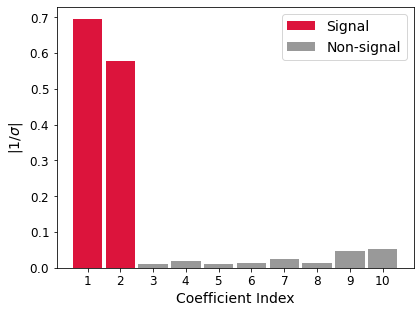

In [84]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

Predictions on test

In [85]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

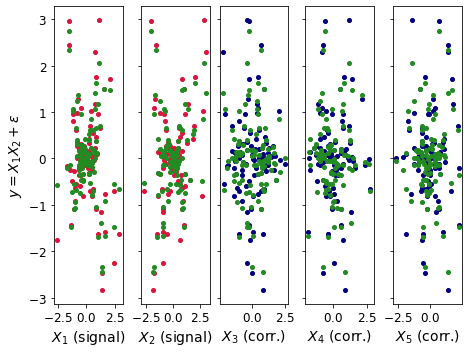

In [86]:
fig, ax = plt.subplots(ncols=5, sharey=True, constrained_layout=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()